### First, this notebook creates a static version of the MODIS product to classify MTBS fires outside of the 2003-2016 MODIS data range. Then, it classifies all fires in MTBS. Finally, this notebook runs a time-varying fit on MTBS data (in 2 grouping methods: 1. individual land cover types and 2. some land cover types split geographically by clusters and others grouped together) in the USA and creates visualizations to show how the CCDF shape changes over time.

In [1]:
import os
import re
import geopandas as gpd
import rasterio
import rasterio.mask
import numpy as np
import pandas as pd
from collections import Counter
from scipy import stats
import pickle
import sys

sys.path.append("..")
from utils.temporal_analysis import *
from utils import wildfire_powerlaw as wfpl

First, build the static raster tiles (so that it can be applied to fires outside 2003-2016)

In [223]:
#REPLACE WITH FILEPATH TO ORIGINAL MTBS DATA
mtbs_gdf = load_shapefile(
    "/Users/lukevonkapff/wildfires/MTBS/S_USA.MTBS_BURN_AREA_BOUNDARY.shp",
    "EPSG:4269",
    area_col="AREA_SQKM"
)

mtbs_filtered = mtbs_gdf[mtbs_gdf["AREA_SQKM"] >= 4].copy()
mtbs_filtered = mtbs_filtered.rename(columns={"YEAR": "year", "AREA_SQKM": "area_km2"})

In [224]:
# REPLACE WITH PATH TO MODIS/GEOTIFF FOLDER (CREATED IN 3_LAND_COVER_CLASSIFICATION NOTEBOOK)
modis_folder = "/Users/lukevonkapff/wildfires/MODIS_USA/GeoTIFF"
modis_files = [os.path.join(modis_folder, f) for f in os.listdir(modis_folder) if f.endswith(".tif")]
modis_by_year = {}
for f in modis_files:
    match = re.search(r"A(\d{4})", os.path.basename(f))
    if match:
        year = int(match.group(1))
        modis_by_year.setdefault(year, []).append(f)

modis_to_gfa = {
    0: "Water",
    1: "Evergreen Needleleaf forest",
    2: "Evergreen Broadleaf forest",
    3: "Deciduous Needleleaf forest",
    4: "Deciduous Broadleaf forest",
    5: "Mixed forest",
    6: "Closed shrublands",
    7: "Open shrublands",
    8: "Woody savannas",
    9: "Savannas",
    10: "Grasslands",
    11: "Permanent wetlands",
    12: "Croplands",
    13: "Urban and built-up",
    14: "Cropland/Natural vegetation mosaic",
    15: "Snow and ice",
    16: "Barren or sparsely vegetated"
}

static_raster = build_static_modis_tiles(modis_by_year)

KeyboardInterrupt: 

Use the static raster to classify all MTBS fires.

In [13]:
mtbs_classified = classify_with_modis(mtbs_filtered, "year", modis_by_year, modis_to_gfa)
mtbs_classified = classify_with_static(mtbs_classified, static_raster, modis_to_gfa)

output_path = "../data/mtbs_classified_static.shp"
mtbs_classified.to_file(output_path)
print(f"Saved GeoDataFrame to {output_path}")

Saved GeoDataFrame to ../data/mtbs_classified_static.shp


Evaluate how well new static raster mapping matches original time-varying raster.

In [195]:
overlap_mask = (mtbs_classified["year"].between(2003, 2016)) & \
               (mtbs_classified["modis_class_timevary"] != "Unknown")

comparison_df = mtbs_classified.loc[overlap_mask].copy()
comparison_df["match"] = (
    comparison_df["modis_class_timevary"] == comparison_df["modis_class_static"]
)

agreement_rate = comparison_df["match"].mean()
print(f"Agreement between time-varying and static MODIS classifications (2003–2016): {agreement_rate:.2%}")
print(comparison_df[["year", "area_km2", "modis_class_timevary", "modis_class_static", "match"]].head())

Agreement between time-varying and static MODIS classifications (2003–2016): 89.68%
      year   area_km2 modis_class_timevary modis_class_static  match
4793  2003  22.834762       Woody savannas     Woody savannas   True
4794  2003   8.722727      Open shrublands         Grasslands  False
4795  2003  13.418604           Grasslands         Grasslands   True
4796  2003   5.596480           Grasslands         Grasslands   True
4797  2003   9.250212           Grasslands         Grasslands   True


## 2 visualizations to justify keeping xmin = 4 cutoff...

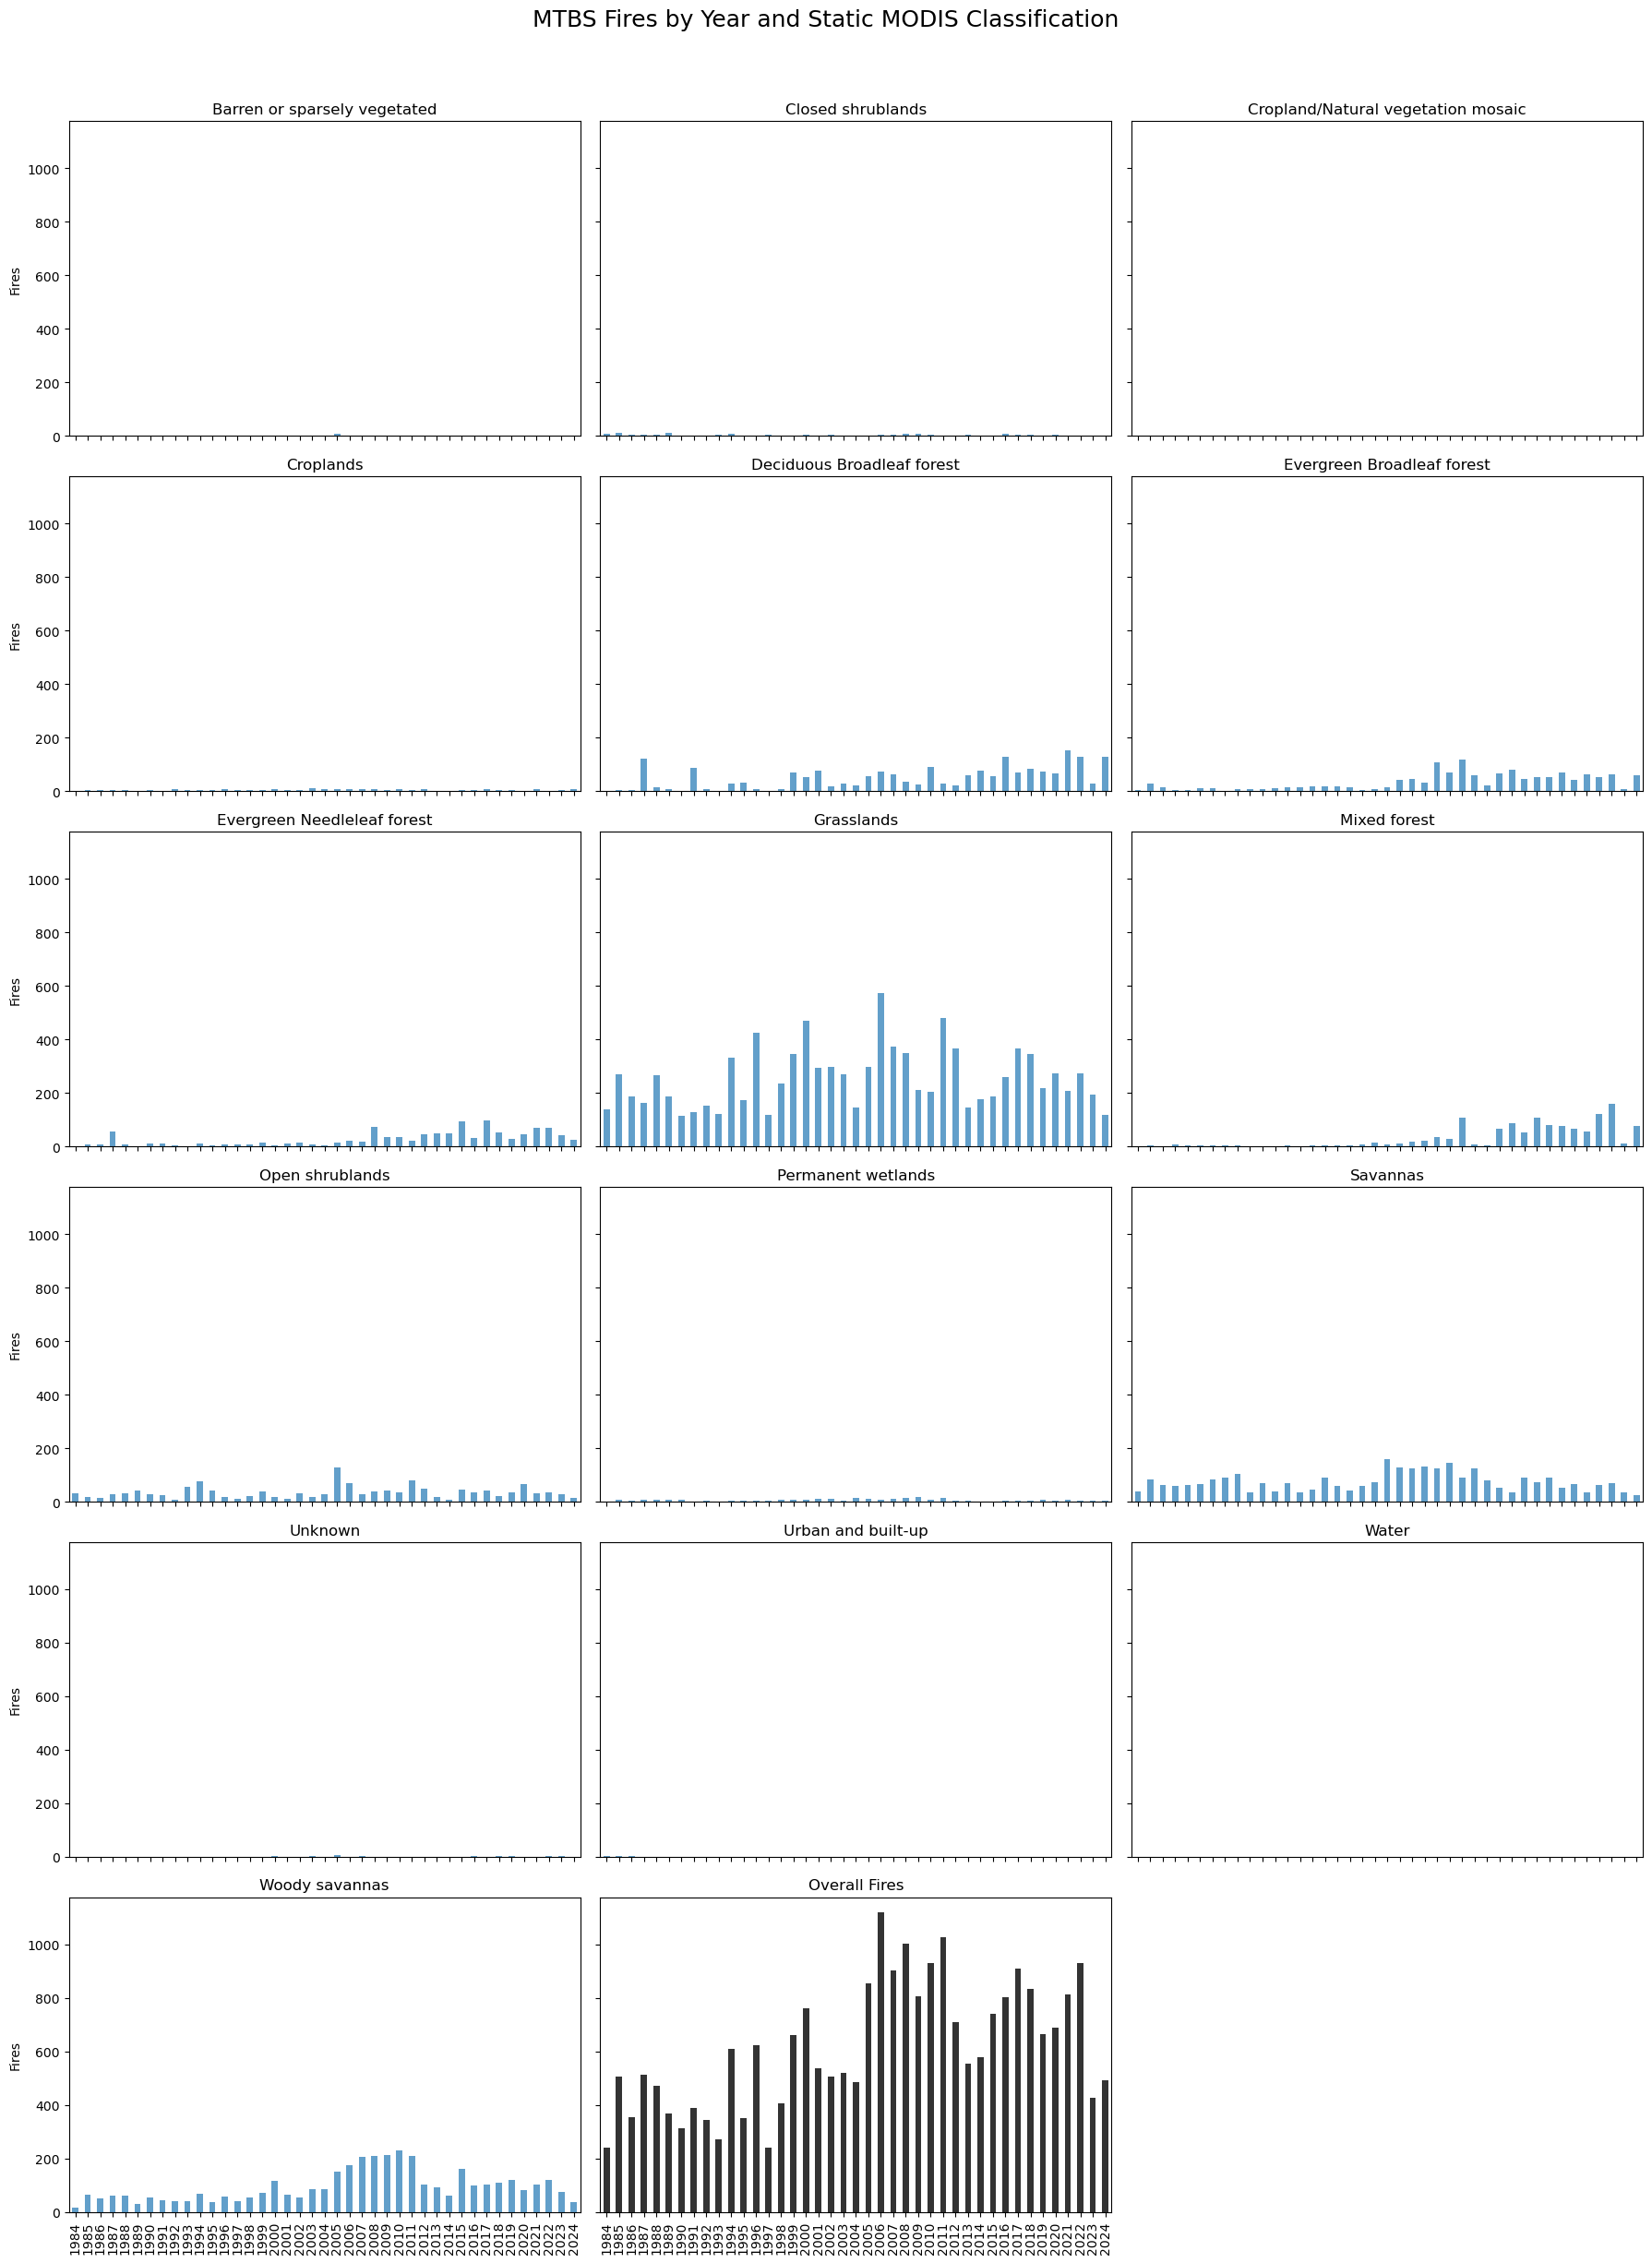

In [19]:
plot_fire_counts_faceted(mtbs_classified)

To visualize where fires in each grouping occur:

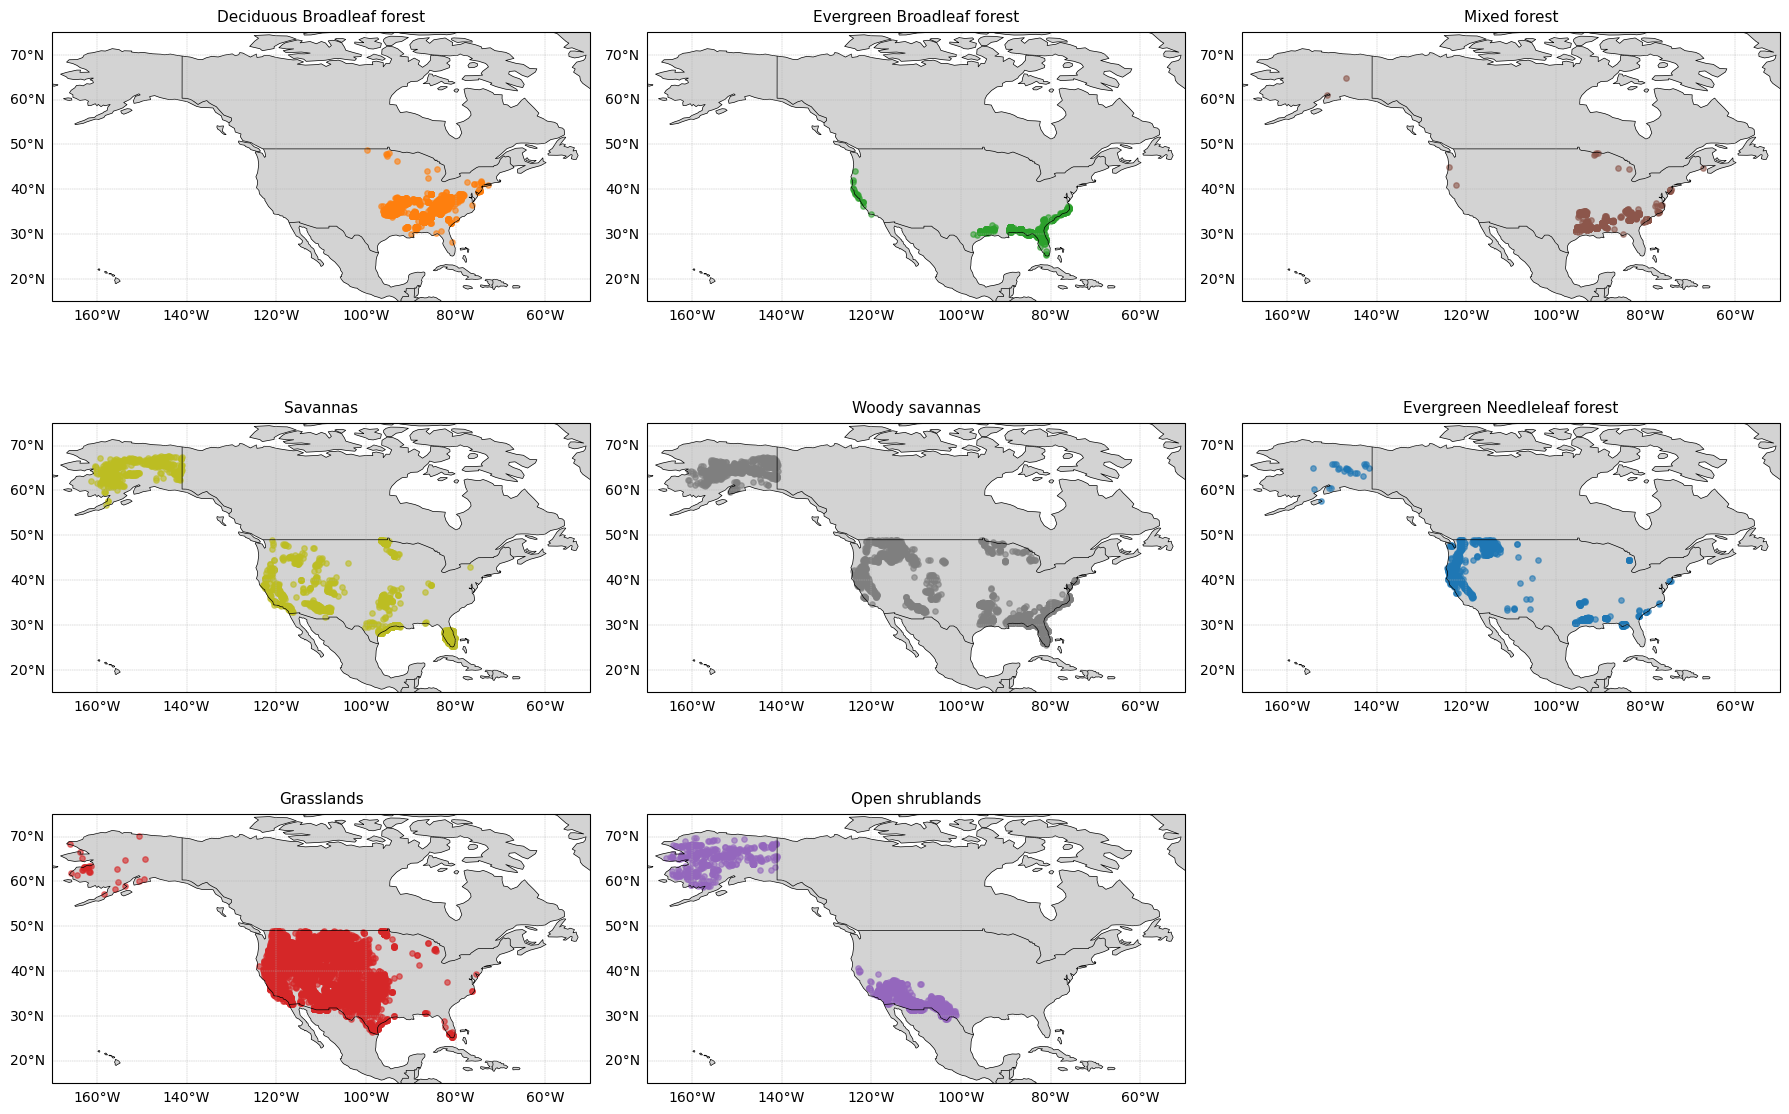

In [57]:
plot_biome_facets(mtbs_classified)

✅ Figure saved to /Users/lukevonkapff/Desktop/EPIC_figures/fires_time_series.png


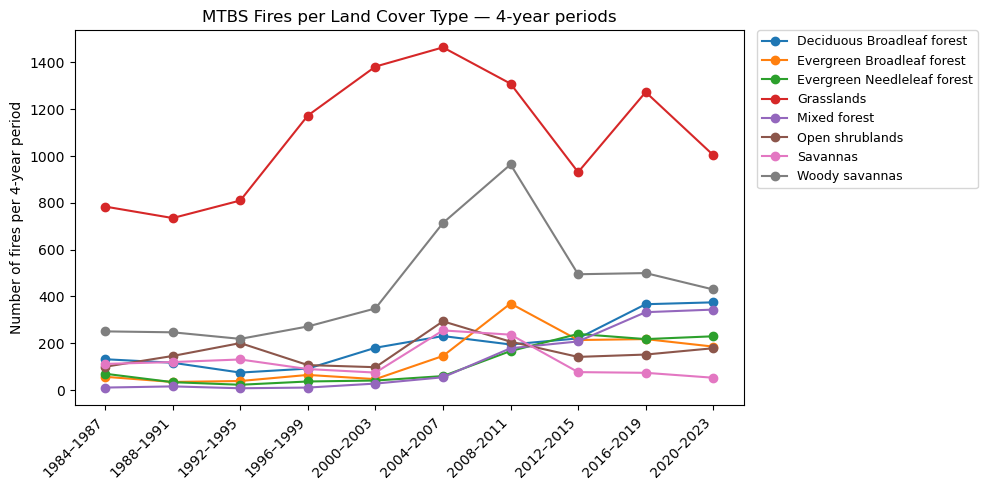

In [193]:
counts_long, counts_wide = fires_time_series_by_ecoregion(
    mtbs_classified,
    year_col="year",
    class_col="modis_class_static",
    period_years=4,
    include_total=False,   # optional
    plot=True
)

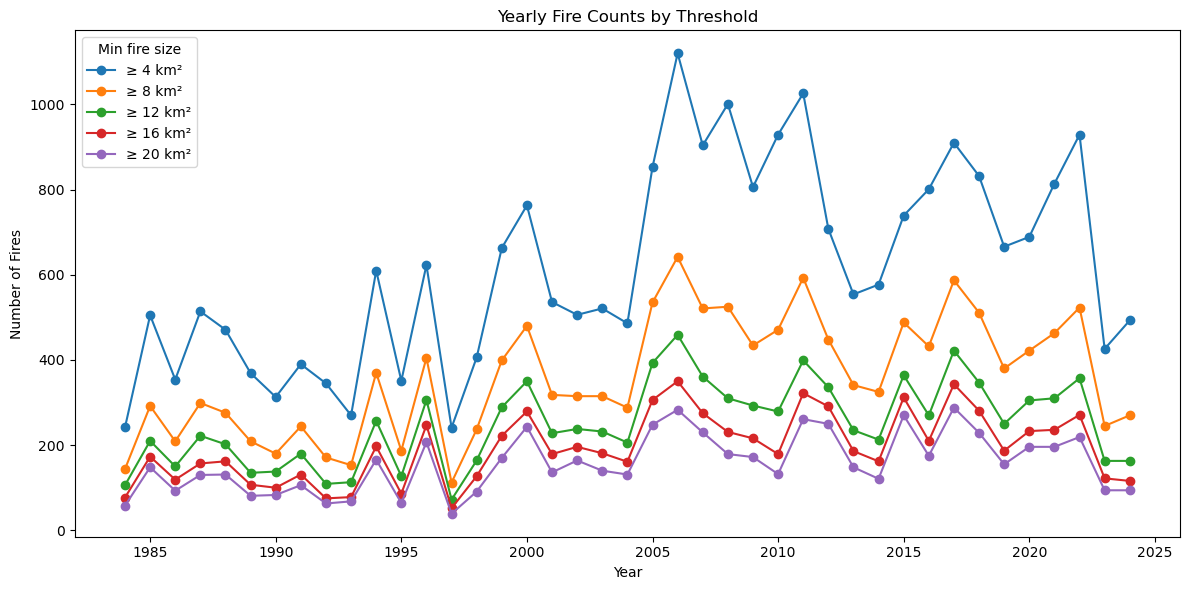

In [20]:
fire_threshold_analysis(mtbs_classified,
                                year_col="year",
                                area_col="area_km2",
                                thresholds=[4, 8, 12, 16, 20])

Thus, there is no other min fire size threshold that will eliminate large jumps in fire size after a certain year, meaning we can stick with 4km2. Now, let's run the fitting routine on each biome using the new land cover classification.

In [22]:
# This cell takes a long time to run -- the overall_results output is in data folder

overall_results = {}

for modis_cat, subset in mtbs_classified.groupby("modis_class_static"):
    data = subset["area_km2"].values
    
    if len(data) == 0:
        continue
    
    print(f"\n=== {modis_cat} (n={len(data)}) ===")
    
    params = wfpl.summarize_parameters_bootstrap(
        data, R=50, xmin=4, random_state=42
    )
    R, best = wfpl.likelihood_matrix_and_best(
        data, xmin=4
    )
    
    overall_results[modis_cat] = {
        "params": params,
        "likelihood_matrix": R,
        "best_fit": best
    }

save_path = "../data/mtbs_static_fits_by_biome.pkl"
with open(save_path, "wb") as f:
    pickle.dump(overall_results, f)

print(f"Saved overall_results to: {save_path}")


=== Barren or sparsely vegetated (n=10) ===
there are 10 points above xmin 4.0 km^2

=== Closed shrublands (n=159) ===
there are 159 points above xmin 4.0 km^2

=== Cropland/Natural vegetation mosaic (n=2) ===
there are 2 points above xmin 4.0 km^2

=== Croplands (n=208) ===
there are 208 points above xmin 4.0 km^2

=== Deciduous Broadleaf forest (n=2041) ===
there are 2041 points above xmin 4.0 km^2

=== Evergreen Broadleaf forest (n=1388) ===
there are 1388 points above xmin 4.0 km^2

=== Evergreen Needleleaf forest (n=1111) ===
there are 1111 points above xmin 4.0 km^2

=== Grasslands (n=10438) ===
there are 10438 points above xmin 4.0 km^2

=== Mixed forest (n=1268) ===
there are 1268 points above xmin 4.0 km^2

=== Open shrublands (n=1433) ===
there are 1433 points above xmin 4.0 km^2

=== Permanent wetlands (n=238) ===
there are 238 points above xmin 4.0 km^2

=== Savannas (n=3044) ===
there are 3044 points above xmin 4.0 km^2

=== Unknown (n=34) ===
there are 34 points above xm

And now, we run the time-varying version of the fitting routine where each parameter is written as p1+p2*t (with modification for truncated power law, see utils). 

In [26]:
timevary_results = analyze_time_varying_mle(mtbs_classified, overall_results, xmin = 4, R_boot = 50)
df_both = summarize_timevary_results_mode(timevary_results, mode="both")


save_path_time_varying = "../data/mtbs_time_varying_fits_by_biome.pkl"
with open(save_path_time_varying, "wb") as f:
    pickle.dump(timevary_results, f)

print(f"Saved overall_results to: {save_path_time_varying}")


=== Barren or sparsely vegetated skipped: only 10 fires above xmin (4) ===

=== Closed shrublands skipped: only 159 fires above xmin (4) ===

=== Cropland/Natural vegetation mosaic skipped: only 2 fires above xmin (4) ===

=== Croplands skipped: only 208 fires above xmin (4) ===

=== Deciduous Broadleaf forest (n=2041 fires ≥ 4) ===

=== Evergreen Broadleaf forest (n=1388 fires ≥ 4) ===

=== Evergreen Needleleaf forest (n=1111 fires ≥ 4) ===

=== Grasslands (n=10438 fires ≥ 4) ===

=== Mixed forest (n=1268 fires ≥ 4) ===

=== Open shrublands (n=1433 fires ≥ 4) ===

=== Permanent wetlands skipped: only 238 fires above xmin (4) ===

=== Savannas (n=3044 fires ≥ 4) ===

=== Unknown skipped: only 34 fires above xmin (4) ===

=== Urban and built-up skipped: only 16 fires above xmin (4) ===

=== Water skipped: only 1 fires above xmin (4) ===

=== Woody savannas (n=3865 fires ≥ 4) ===
Saved overall_results to: ../data/mtbs_time_varying_fits_by_biome.pkl


Now, to view the results from the time-varying fits...

In [53]:
df_both = summarize_timevary_results_mode(timevary_results, mode="both")
df_p1 = summarize_timevary_results_mode(timevary_results, mode="p1_only")
df_p2 = summarize_timevary_results_mode(timevary_results, mode="p2_only")
df_both

biome           distribution      n         p1  \
0    Deciduous Broadleaf forest     generalized_pareto   2041   0.470531   
1    Evergreen Broadleaf forest     generalized_pareto   1388   0.408186   
2   Evergreen Needleleaf forest              lognormal   1111   2.804982   
3   Evergreen Needleleaf forest  stretched_exponential   1111  26.265964   
4   Evergreen Needleleaf forest    truncated_power_law   1111   1.560384   
5   Evergreen Needleleaf forest                weibull   1111   0.694156   
6                    Grasslands              lognormal  10438   2.719330   
7                    Grasslands  stretched_exponential  10438  12.333152   
8                    Grasslands                weibull  10438   0.729872   
9                  Mixed forest     generalized_pareto   1268   0.426512   
10                 Mixed forest              lognormal   1268   1.996058   
11              Open shrublands              lognormal   1433   2.909951   
12              Open shrublands  stretched_exponential   1433  18.064348   
13              Open shrublands                weibull   1433   0.694652   
14                     Savannas    truncated_power_law   3044   1.841777   
15               Woody savannas    truncated_power_law   3865   1.809728   

           p1_se       p1'    p1'_se         p2         p2_se       p2'  \
0   5.882589e-02 -0.086010  0.048334   4.669513  2.669932e-01 -0.809641   
1   6.275691e-02 -0.164975  0.057368   5.071971  3.293930e-01  0.318179   
2   7.342493e-02  0.099899  0.069931   1.186876  7.299636e-02  0.100074   
3   1.025356e+01 -0.168502  0.533259   0.207096  1.161735e-02 -0.012629   
4   3.594106e-16 -0.176678  0.287779   0.000787  2.168404e-19  0.000655   
5   2.485206e-02 -0.059793  0.023921  32.045860  2.888891e+00  4.044019   
6   5.399728e-02  0.048189  0.050525   1.096842  3.212381e-02  0.052059   
7   1.206149e+01 -0.358208  0.527522   0.229822  1.105827e-02 -0.004910   
8   2.379182e-02 -0.037011  0.020048  27.753393  1.687791e+00  2.092591   
9   8.396930e-02 -0.224249  0.073964   2.924505  3.219464e-01  0.674780   
10  3.471326e-02  0.014526  0.028861   0.529538  3.235913e-02 -0.061917   
11  6.458187e-02  0.124445  0.058979   1.202330  5.928552e-02  0.092589   
12  1.029358e+01 -0.853533  0.522738   0.206708  1.394934e-02 -0.008035   
13  3.132048e-02 -0.027589  0.023701  35.696460  2.727335e+00  6.500159   
14  0.000000e+00 -0.095025  0.444515   0.000349  0.000000e+00 -0.000057   
15  2.220446e-16  0.088585  0.380699   0.000287  0.000000e+00 -0.000053   

      p2'_se  p1_slope_sig  p2_slope_sig  
0   0.211527             0             1  
1   0.275185             1             0  
2   0.062230             0             0  
3   0.003860             0             1  
4   0.000448             0             0  
5   1.716100             1             1  
6   0.036271             0             0  
7   0.001843             0             1  
8   1.410271             0             0  
9   0.246461             1             1  
10  0.027875             0             1  
11  0.041834             1             1  
12  0.002437             0             1  
13  1.407845             0             1  
14  0.000156             0             0  
15  0.000172             0             0

Or just the "main" ones...

In [63]:
summary_table = summarize_ecoregion_fits(df_both, df_p1, df_p2, overall_results)
summary_table

biome         distribution      n   Δloglik  \
0   Deciduous Broadleaf forest   generalized_pareto   2041  0.000000   
1   Evergreen Broadleaf forest   generalized_pareto   1388  0.000000   
2                 Mixed forest   generalized_pareto   1268  0.000000   
3                     Savannas  truncated_power_law   3044  0.000000   
4               Woody savannas  truncated_power_law   3865  0.000000   
5  Evergreen Needleleaf forest            lognormal   1111  1.403200   
6                   Grasslands            lognormal  10438  0.000000   
7              Open shrublands            lognormal   1433  0.707255   

         p1 ± se        p2 ± se        Δp1 ± se        Δp2 ± se  
0  0.471 ± 0.059  4.670 ± 0.267                  -0.810 ± 0.212  
1  0.408 ± 0.063  5.072 ± 0.329  -0.165 ± 0.057                  
2  0.427 ± 0.084  2.925 ± 0.322  -0.224 ± 0.074                  
3  1.842 ± 0.000  0.000 ± 0.000                                  
4  1.810 ± 0.000  0.000 ± 0.000                                  
5  2.805 ± 0.073  1.187 ± 0.073                                  
6  2.719 ± 0.054  1.097 ± 0.032                                  
7  2.910 ± 0.065  1.202 ± 0.059   0.124 ± 0.059

And just the additional fits...

In [64]:
summary_other = summarize_other_fits(df_both, df_p1, df_p2, overall_results)
summary_other

biome           distribution      n       Δloglik  \
0  Evergreen Needleleaf forest  stretched_exponential   1111  8.135237e-01   
1  Evergreen Needleleaf forest    truncated_power_law   1111  0.000000e+00   
2  Evergreen Needleleaf forest                weibull   1111  8.135274e-01   
3                   Grasslands  stretched_exponential  10438  1.834964e+00   
4                   Grasslands                weibull  10438  1.834966e+00   
5                 Mixed forest              lognormal   1268  1.841576e+00   
6              Open shrublands  stretched_exponential   1433  0.000000e+00   
7              Open shrublands                weibull   1433  9.781070e-08   

           p1 ± se         p2 ± se        Δp1 ± se        Δp2 ± se  
0  26.266 ± 10.254   0.207 ± 0.012                  -0.013 ± 0.004  
1    1.560 ± 0.000   0.001 ± 0.000                                  
2    0.694 ± 0.025  32.046 ± 2.889  -0.060 ± 0.024   4.044 ± 1.716  
3  12.333 ± 12.061   0.230 ± 0.011                  -0.005 ± 0.002  
4    0.730 ± 0.024  27.753 ± 1.688                                  
5    1.996 ± 0.035   0.530 ± 0.032                                  
6  18.064 ± 10.294   0.207 ± 0.014                  -0.008 ± 0.002  
7    0.695 ± 0.031  35.696 ± 2.727                   6.500 ± 1.408

Or all of them in that format...

In [207]:
results_table = summarize_all_fits(df_both, df_p1, df_p2, overall_results)
results_table

biome        distribution     n   Δloglik  \
0  Deciduous Broadleaf forest  generalized_pareto  2041  0.000000   
1  Evergreen Broadleaf forest  generalized_pareto  1388  0.000000   
2                Mixed forest  generalized_pareto  1268  0.000000   
3                Mixed forest           lognormal  1268  1.841576   

         p1 ± se        p2 ± se        Δp1 ± se        Δp2 ± se  
0  0.471 ± 0.059  4.670 ± 0.267                  -0.810 ± 0.212  
1  0.408 ± 0.063  5.072 ± 0.329  -0.165 ± 0.057                  
2  0.427 ± 0.084  2.925 ± 0.322  -0.224 ± 0.074                  
3  1.996 ± 0.035  0.530 ± 0.032

Below are a set of plotting functions to visualize how well the fits match the data qualitatively.

✅ Figure saved to /Users/lukevonkapff/Desktop/EPIC_figures/mixed_forest_cdf_ccdf_qq.png


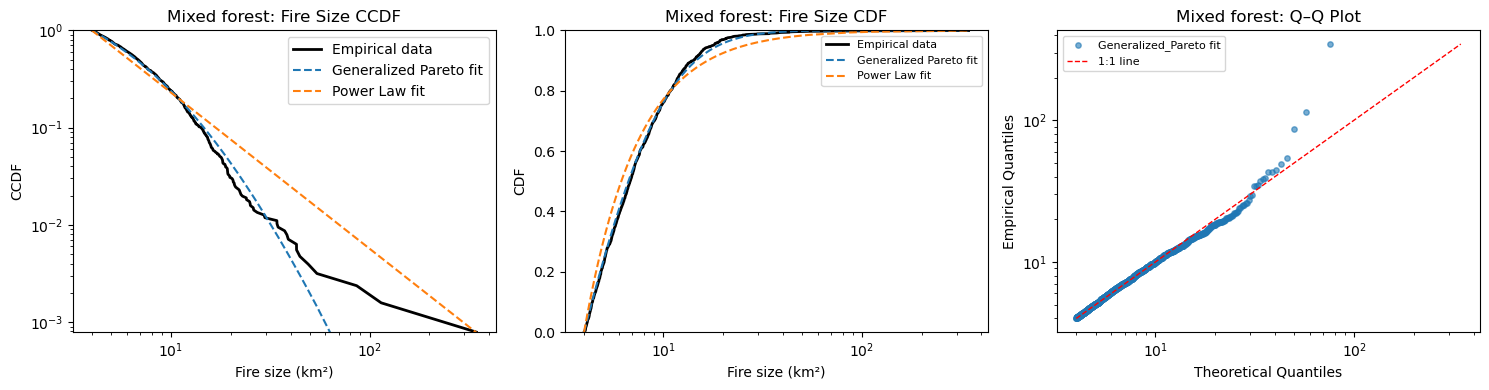

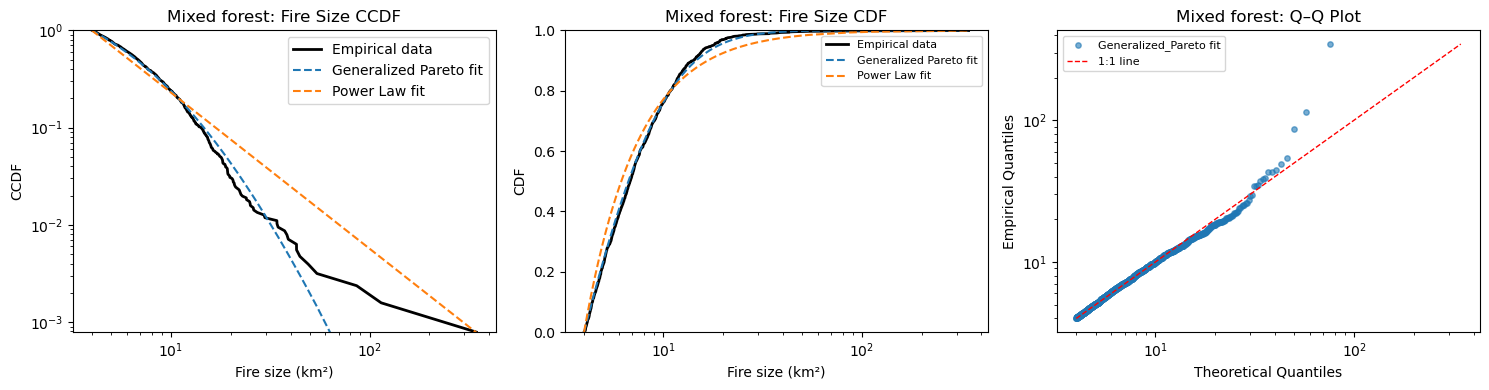

In [209]:
plot_modis_category_ccdf_cdf_qq(mtbs_classified, "Mixed forest", which = ["generalized_pareto", "power_law"])

Figure saved to /Users/lukevonkapff/Desktop/EPIC_figures/deciduous broadleaf forest_generalized_pareto_over_time.png


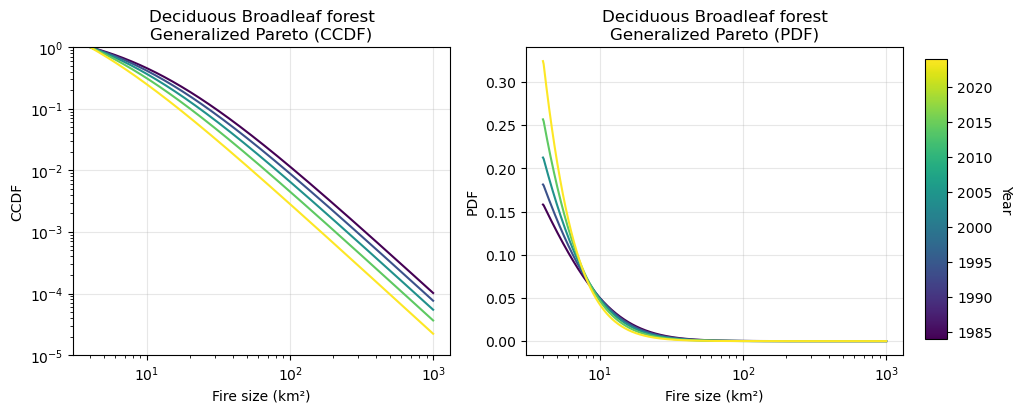

Figure saved to /Users/lukevonkapff/Desktop/EPIC_figures/evergreen broadleaf forest_generalized_pareto_over_time.png


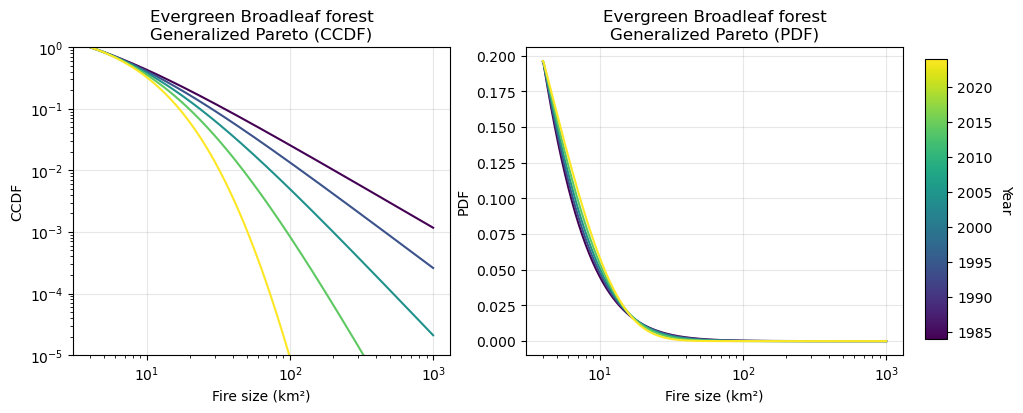

Figure saved to /Users/lukevonkapff/Desktop/EPIC_figures/evergreen needleleaf forest_lognormal_over_time.png


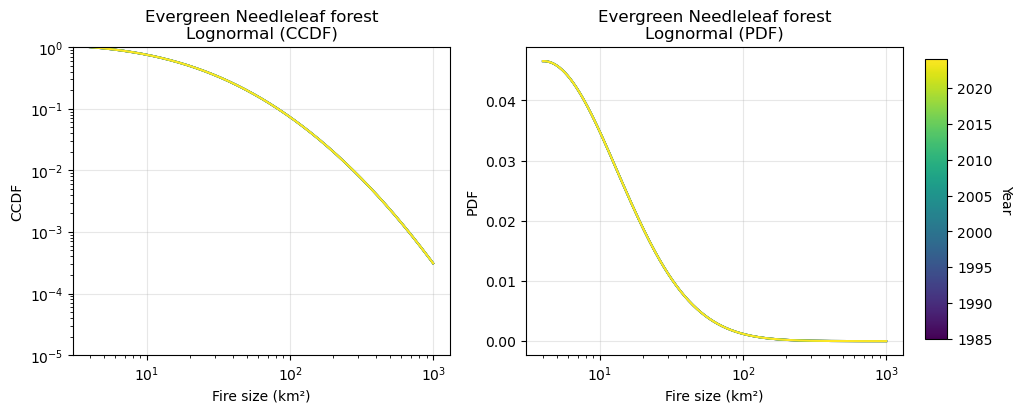

Figure saved to /Users/lukevonkapff/Desktop/EPIC_figures/evergreen needleleaf forest_stretched_exponential_over_time.png


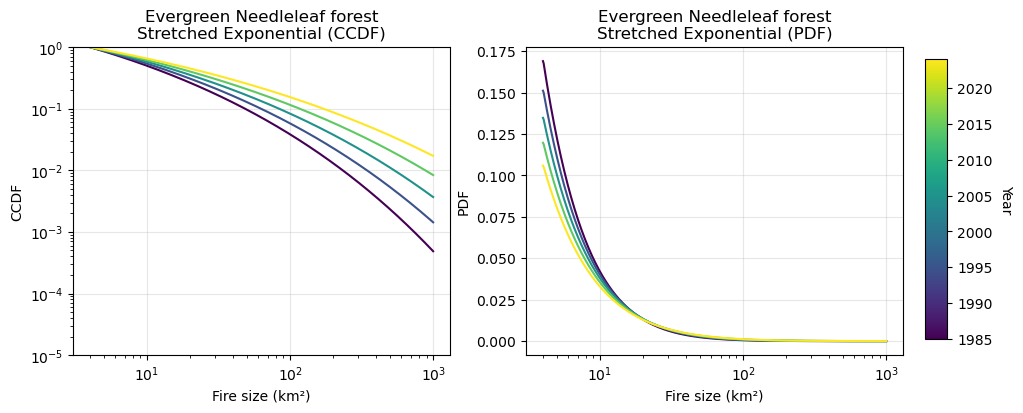

Figure saved to /Users/lukevonkapff/Desktop/EPIC_figures/evergreen needleleaf forest_truncated_power_law_over_time.png


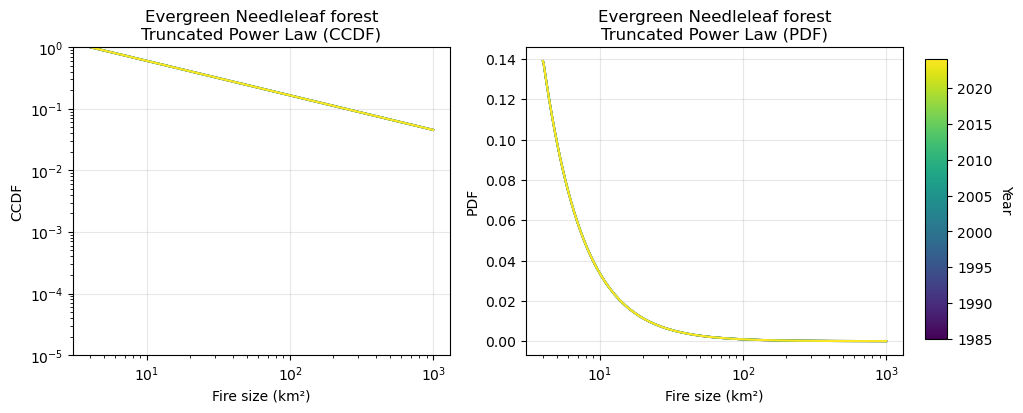

Figure saved to /Users/lukevonkapff/Desktop/EPIC_figures/evergreen needleleaf forest_weibull_over_time.png


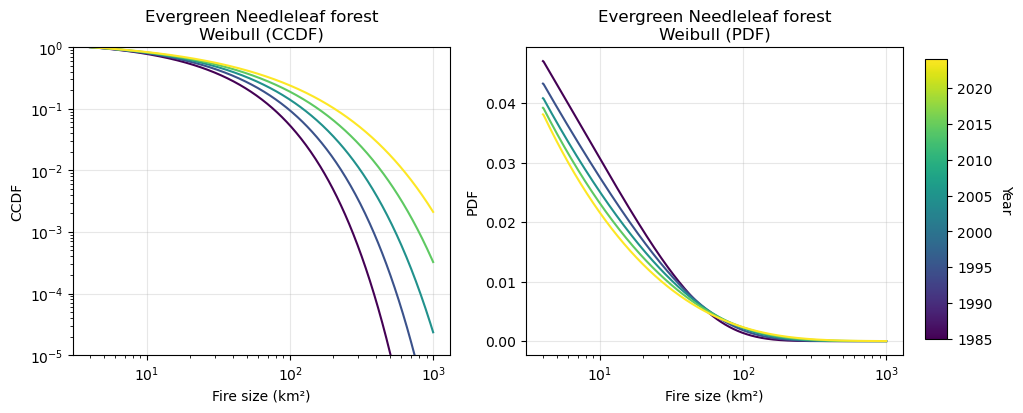

Figure saved to /Users/lukevonkapff/Desktop/EPIC_figures/grasslands_lognormal_over_time.png


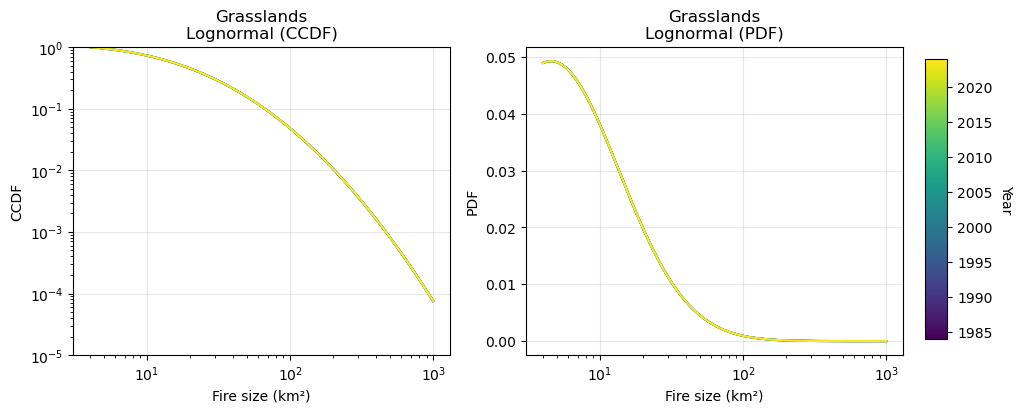

Figure saved to /Users/lukevonkapff/Desktop/EPIC_figures/grasslands_stretched_exponential_over_time.png


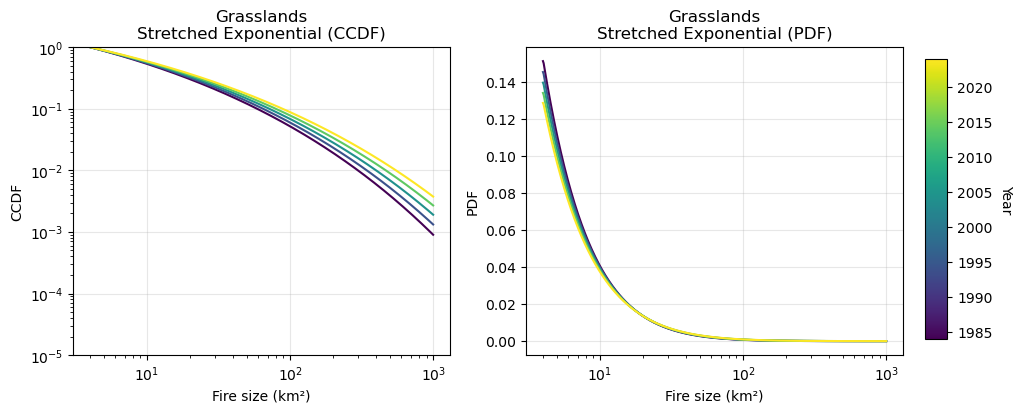

Figure saved to /Users/lukevonkapff/Desktop/EPIC_figures/grasslands_weibull_over_time.png


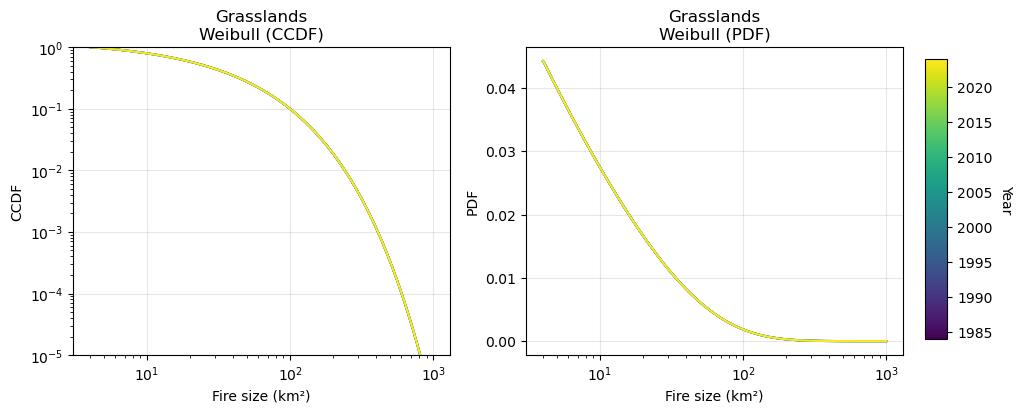

Figure saved to /Users/lukevonkapff/Desktop/EPIC_figures/mixed forest_generalized_pareto_over_time.png


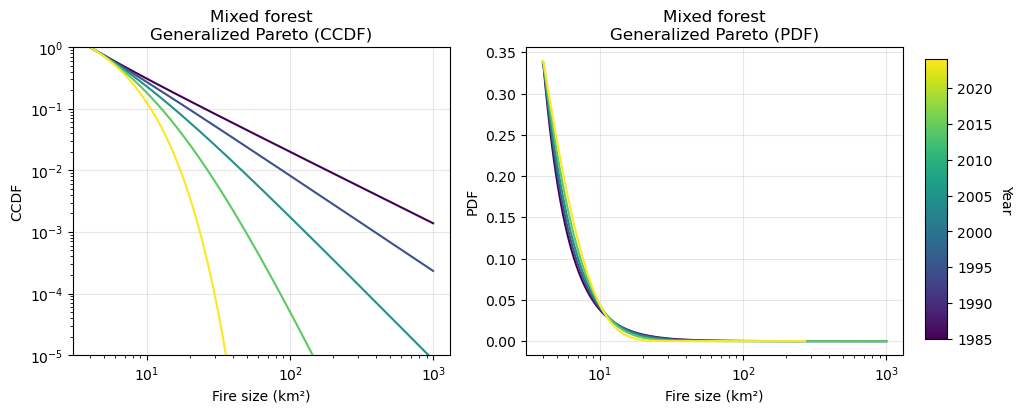

Figure saved to /Users/lukevonkapff/Desktop/EPIC_figures/mixed forest_lognormal_over_time.png


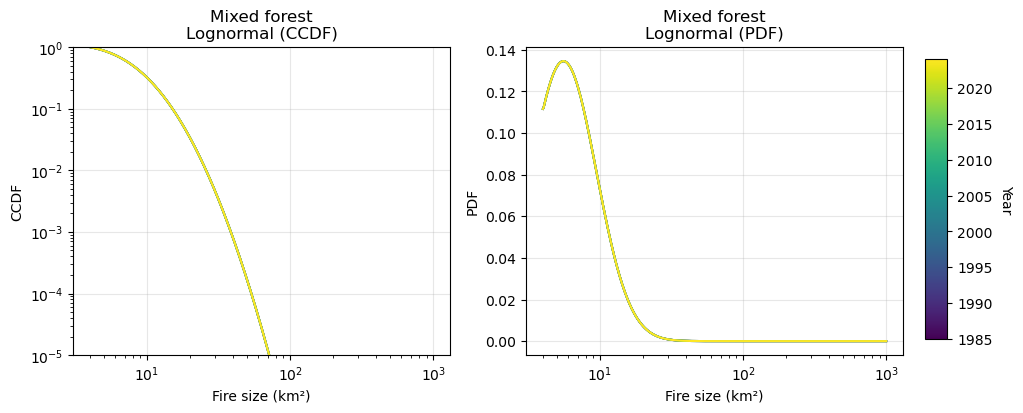

Figure saved to /Users/lukevonkapff/Desktop/EPIC_figures/open shrublands_lognormal_over_time.png


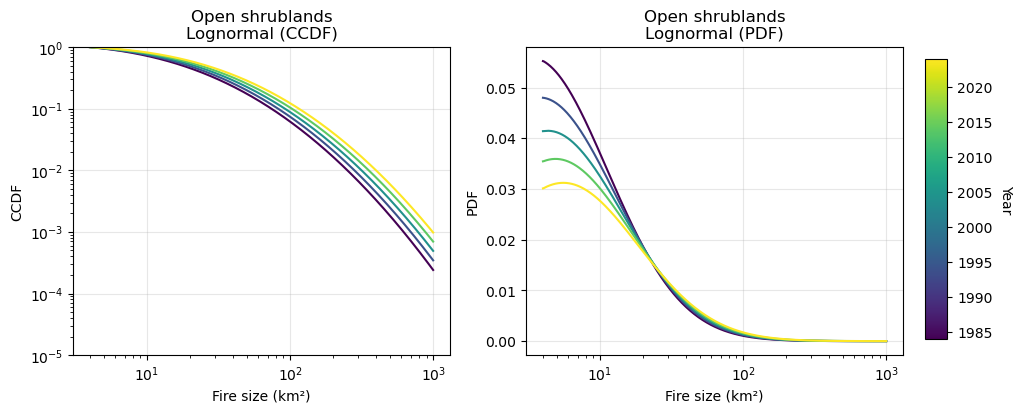

Figure saved to /Users/lukevonkapff/Desktop/EPIC_figures/open shrublands_stretched_exponential_over_time.png


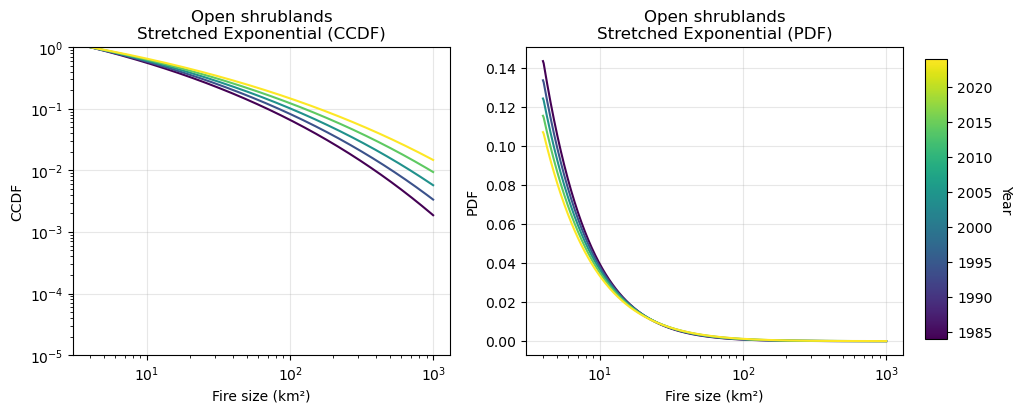

Figure saved to /Users/lukevonkapff/Desktop/EPIC_figures/open shrublands_weibull_over_time.png


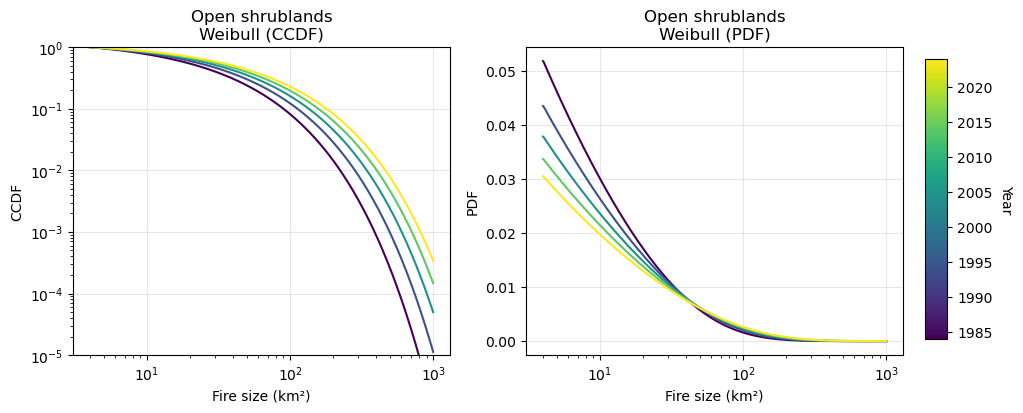

Figure saved to /Users/lukevonkapff/Desktop/EPIC_figures/savannas_truncated_power_law_over_time.png


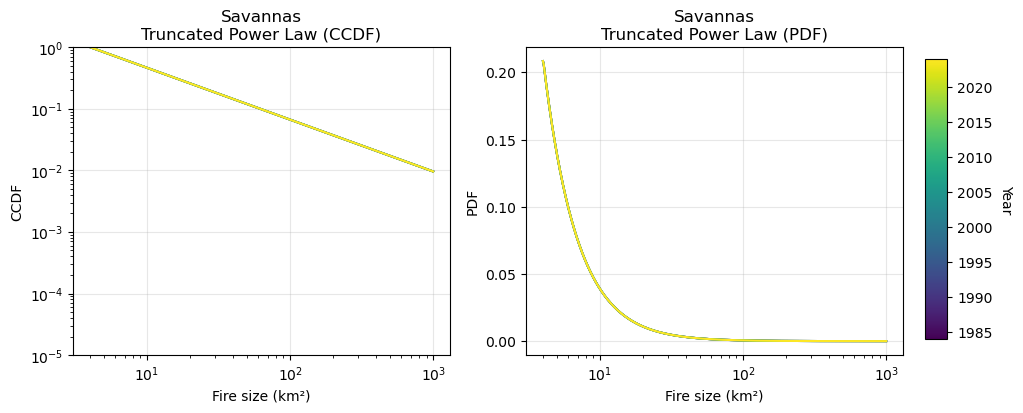

Figure saved to /Users/lukevonkapff/Desktop/EPIC_figures/woody savannas_truncated_power_law_over_time.png


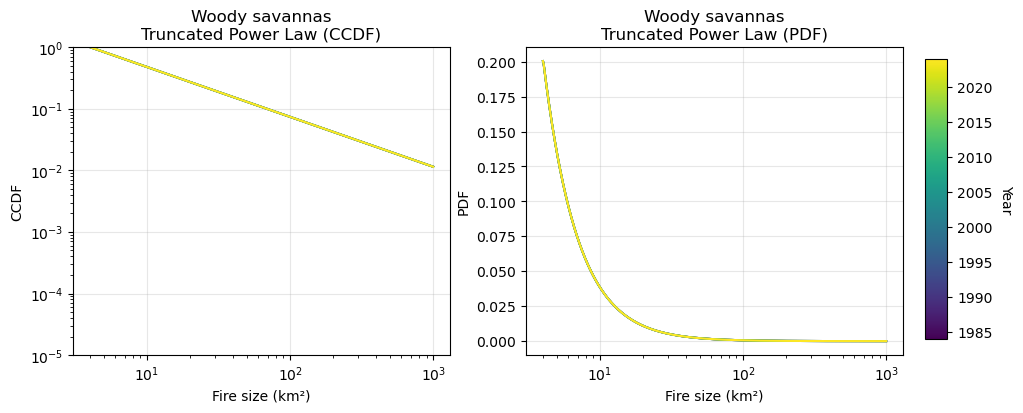

In [172]:
plot_distribution_evolution_ccdf_pdf(
    df_both,
    mtbs_classified,
    df_p1=df_p1,
    df_p2=df_p2,
    xmin=4
)

The following function runs a Poisson regression on each land cover type and is used to determine if change in tail shape is due to relative change in either small or large fires (or both).

In [ ]:
poisson_by_biome = fit_poisson_tail_trend_by_biome_highres(mtbs_classified)
poisson_by_biome

Based on the spatial distribution of fires in each land cover type, the following cell groups them into the groupings and reruns the fitting routine on these new groupings.

- Deciduous Broadleaf forests
- Evergreen Broadleaf forests
- Evergreen Broadleaf forests in the American South
- Evergreen Broadleaf forests on the West Coast
- Grasslands
- Grasslands and American Southwest Open Shrublands
- Open Shrublands
- Open Shrublands in the American Southwest
- Open Shrublands in Alaska

The other biomes are not included in this grouping because they were too scattered around the US without clear clusters.

In [9]:
SAVE_PATH = "../data/mtbs_static_fits_by_biome_refined.pkl"

# Explicitly define the four biomes we care about
valid_biomes = [
    "Deciduous Broadleaf forest",
    "Evergreen Broadleaf forest",
    "Open shrublands",
    "Grasslands",
]

df = mtbs_classified.copy()
df = df[df["modis_cl_1"].isin(valid_biomes)].copy()

if "LONGITUDE" not in df.columns:
    raise ValueError("Expected column 'LONGITUDE' not found in mtbs_classified")

def assign_refined_label(biome: str, lon: float) -> str:
    """Return the correct refined biome label based on biome and longitude."""
    if biome == "Deciduous Broadleaf forest":
        return "Deciduous Broadleaf forest"

    elif biome == "Evergreen Broadleaf forest":
        if lon < -100:
            return "Evergreen Broadleaf forest W of 100W"
        else:
            return "Evergreen Broadleaf forest E of 100W"

    elif biome == "Open shrublands":
        if lon < -130:
            return "Open shrublands W of 130W"
        else:
            return "Open shrublands E of 130W"

    elif biome == "Grasslands":
        return "Grasslands"

    else:
        return None
    
def subset_union(df, members, new_label):
    """Concatenate subset DataFrames and assign a new label."""
    sub = df[df["biome_refined"].isin(members)].copy()
    sub["biome_refined"] = new_label
    return sub

df["biome_refined"] = [
    assign_refined_label(b, lon)
    for b, lon in zip(df["modis_cl_1"], df["LONGITUDE"])
]

group_frames = []

# 1. All deciduous broadleaf
group_frames.append(df[df["biome_refined"] == "Deciduous Broadleaf forest"].copy())

# 2. All evergreen broadleaf (union of east + west)
group_frames.append(
    subset_union(
        df,
        ["Evergreen Broadleaf forest E of 100W", "Evergreen Broadleaf forest W of 100W"],
        "Evergreen Broadleaf forest",
    )
)

# 3. Evergreen broadleaf east subset
group_frames.append(df[df["biome_refined"] == "Evergreen Broadleaf forest E of 100W"].copy())

# 4. Evergreen broadleaf west subset
group_frames.append(df[df["biome_refined"] == "Evergreen Broadleaf forest W of 100W"].copy())

# 5. All grasslands
group_frames.append(df[df["biome_refined"] == "Grasslands"].copy())

# 6. All open shrublands (union of east + west)
group_frames.append(
    subset_union(
        df,
        ["Open shrublands E of 130W", "Open shrublands W of 130W"],
        "Open shrublands",
    )
)

# 7. Open shrublands west subset
group_frames.append(df[df["biome_refined"] == "Open shrublands W of 130W"].copy())

# 8. Open shrublands east subset
group_frames.append(df[df["biome_refined"] == "Open shrublands E of 130W"].copy())

# 9. Grasslands + open shrublands east combo
group_frames.append(
    subset_union(
        df,
        ["Grasslands", "Open shrublands E of 130W"],
        "Grasslands + Open shrublands E of 130W",
    )
)

# Combine all nine explicitly
df_refined = pd.concat(group_frames, ignore_index=True)

print("Final refined grouping counts:")
print(df_refined["biome_refined"].value_counts())
print(f"\nTotal fires included: {len(df_refined)}")

# === Step 4: Run WFPL fits for these 9 groups only ===
overall_results_refined = {}

for group_label, subset in df_refined.groupby("biome_refined"):
    data = subset["area_km2"].values
    if len(data) == 0:
        print(f"⚠️ Skipping {group_label} (no fires in subset)")
        continue

    print(f"\n=== {group_label} (n={len(data)}) ===")
    params = wfpl.summarize_parameters_bootstrap(data, R=50, xmin=4, random_state=42)
    R, best = wfpl.likelihood_matrix_and_best(data, xmin=4)

    overall_results_refined[group_label] = {
        "params": params,
        "likelihood_matrix": R,
        "best_fit": best,
    }

with open(SAVE_PATH, "wb") as f:
    pickle.dump(overall_results_refined, f)

print(f"\nSaved refined fits to: {SAVE_PATH}")



Final refined grouping counts:
biome_refined
Grasslands + Open shrublands E of 130W    11456
Grasslands                                10438
Deciduous Broadleaf forest                 2041
Open shrublands                            1433
Evergreen Broadleaf forest                 1388
Evergreen Broadleaf forest E of 100W       1368
Open shrublands E of 130W                  1018
Open shrublands W of 130W                   415
Evergreen Broadleaf forest W of 100W         20
Name: count, dtype: int64

Total fires included: 29577

=== Deciduous Broadleaf forest (n=2041) ===
there are 2041 points above xmin 4.0 km^2

=== Evergreen Broadleaf forest (n=1388) ===
there are 1388 points above xmin 4.0 km^2

=== Evergreen Broadleaf forest E of 100W (n=1368) ===
there are 1368 points above xmin 4.0 km^2

=== Evergreen Broadleaf forest W of 100W (n=20) ===
there are 20 points above xmin 4.0 km^2

=== Grasslands (n=10438) ===
there are 10438 points above xmin 4.0 km^2

=== Grasslands + Open shrublan

And then we run the time-varying fits on these groupings.

In [10]:
timevary_results_refined = analyze_time_varying_mle_refined(
    mtbs_classified, overall_results_refined, xmin=4, R_boot=50
)
df_both_refined = summarize_timevary_results_mode(timevary_results_refined, mode="both")
df_p1_refined = summarize_timevary_results_mode(timevary_results_refined, mode="p1_only")
df_p2_refined = summarize_timevary_results_mode(timevary_results_refined, mode="p2_only")



✅ Refined group counts for time-varying MLE:
biome_refined
Grasslands + Open shrublands E of 130W    11456
Grasslands                                10438
Deciduous Broadleaf forest                 2041
Open shrublands                            1433
Evergreen Broadleaf forest                 1388
Evergreen Broadleaf forest E of 100W       1368
Open shrublands E of 130W                  1018
Open shrublands W of 130W                   415
Evergreen Broadleaf forest W of 100W         20
Name: count, dtype: int64

=== Deciduous Broadleaf forest (n=2041 fires ≥ 4) ===

=== Evergreen Broadleaf forest (n=1388 fires ≥ 4) ===

=== Evergreen Broadleaf forest E of 100W (n=1368 fires ≥ 4) ===

=== Evergreen Broadleaf forest W of 100W skipped: only 20 fires ≥ 4 ===

=== Grasslands (n=10438 fires ≥ 4) ===

=== Grasslands + Open shrublands E of 130W (n=11456 fires ≥ 4) ===

=== Open shrublands (n=1433 fires ≥ 4) ===

=== Open shrublands E of 130W (n=1018 fires ≥ 4) ===

=== Open shrublands W of 13

In [28]:
timevary_summary = summarize_all_fits_general(df_both_refined, df_p1_refined, df_p2_refined, overall_results_refined)
timevary_summary

Final refined grouping counts:
biome_refined
Grasslands + Open shrublands E of 130W    11456
Grasslands                                10438
Deciduous Broadleaf forest                 2041
Open shrublands                            1433
Evergreen Broadleaf forest                 1388
Evergreen Broadleaf forest E of 100W       1368
Open shrublands E of 130W                  1018
Open shrublands W of 130W                   415
Evergreen Broadleaf forest W of 100W         20
Name: count, dtype: int64

Total fires included: 29577


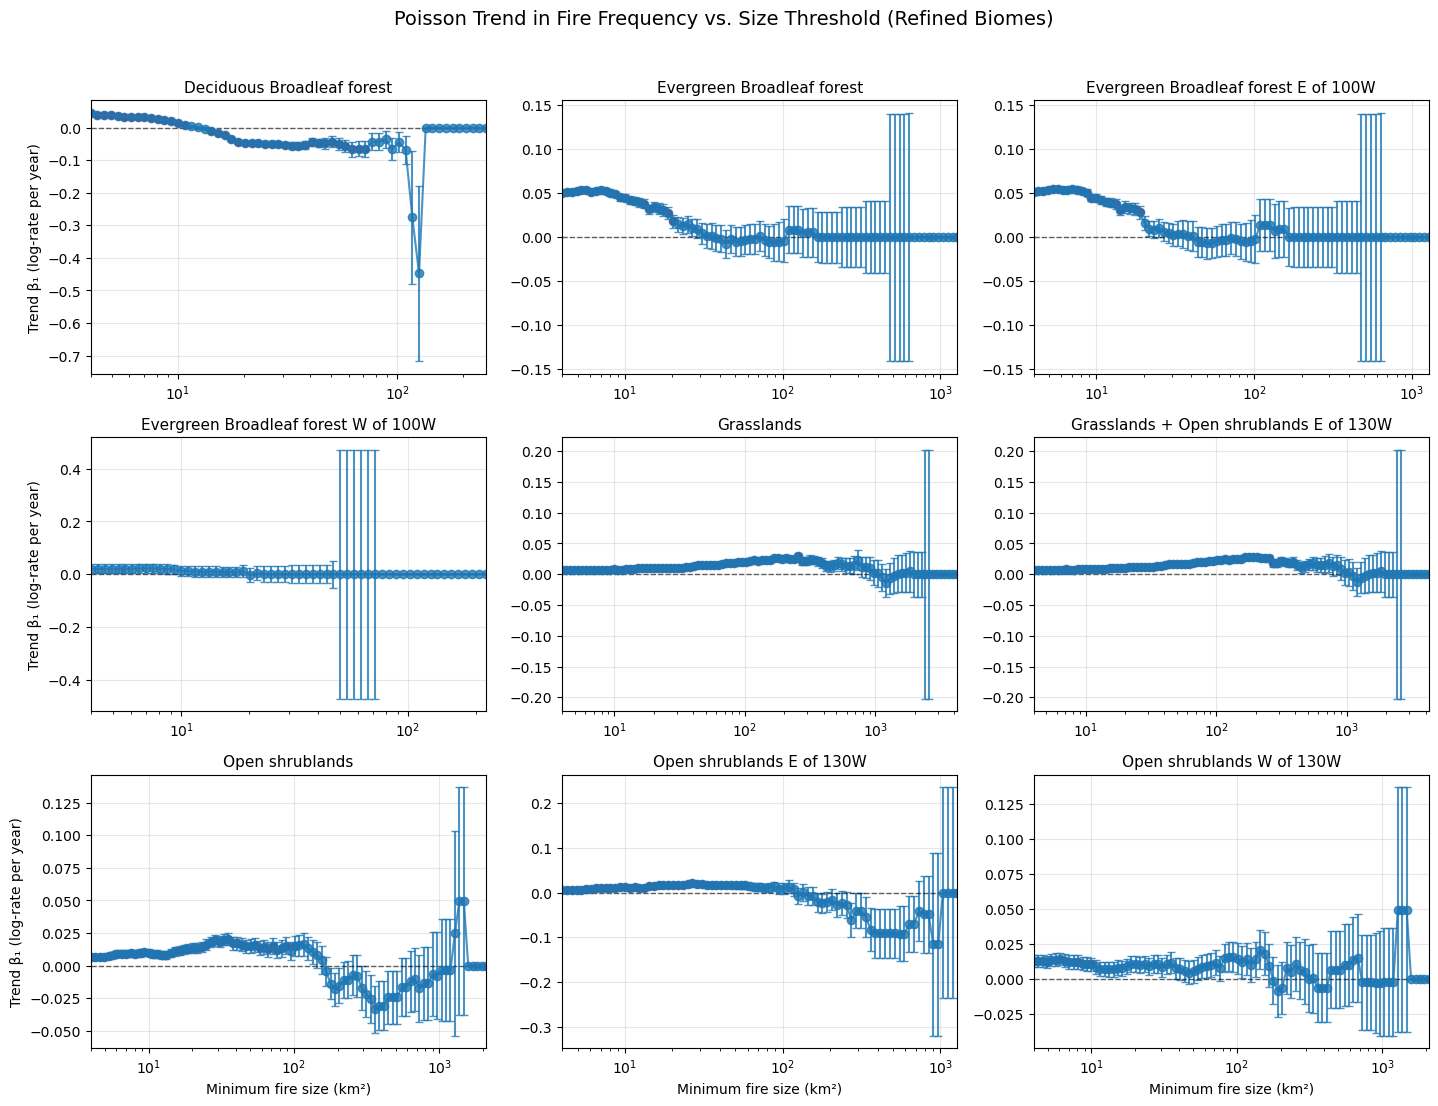

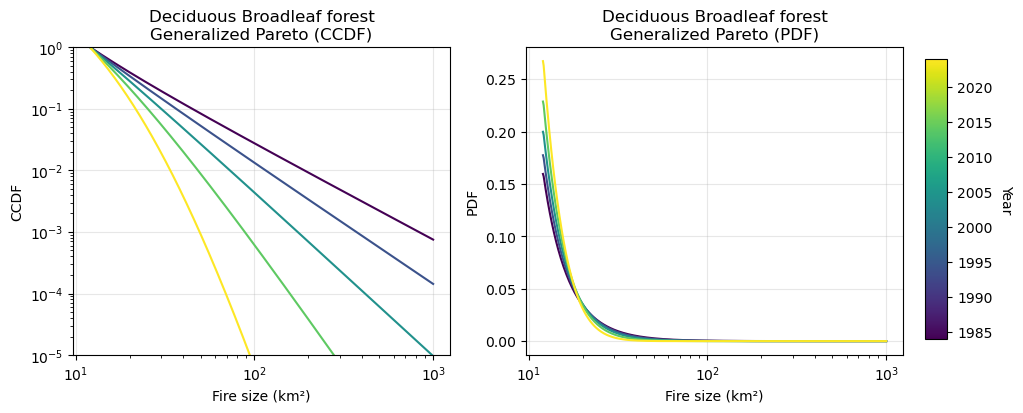

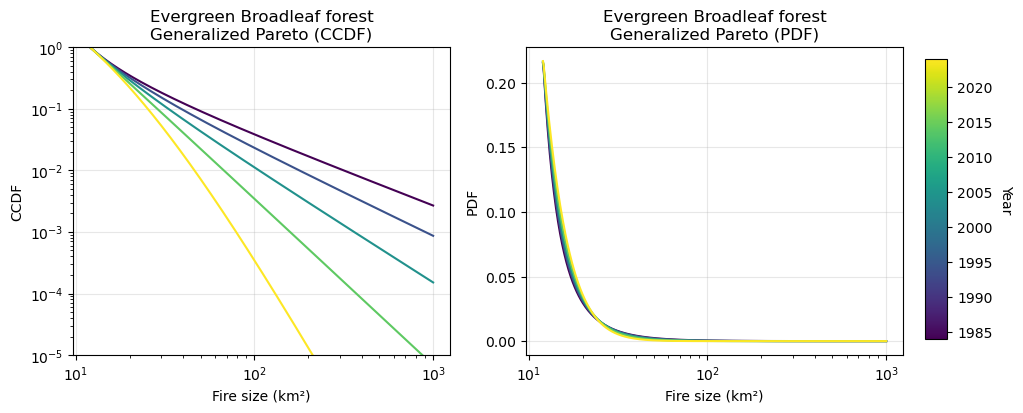

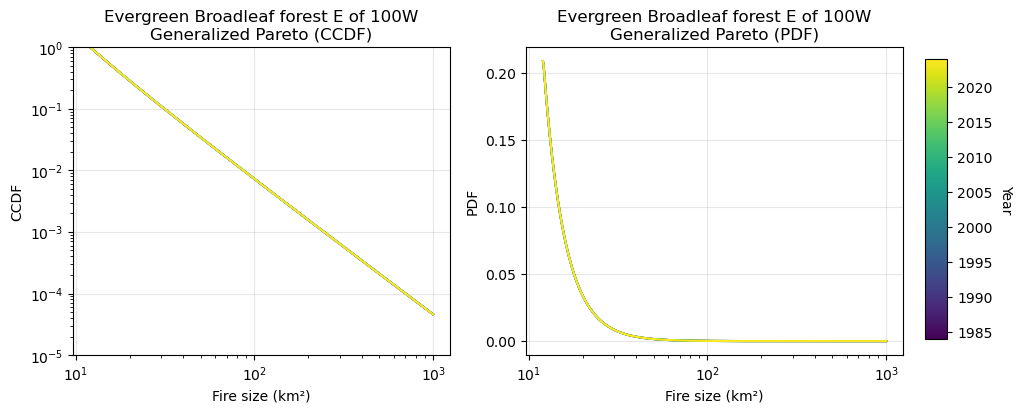

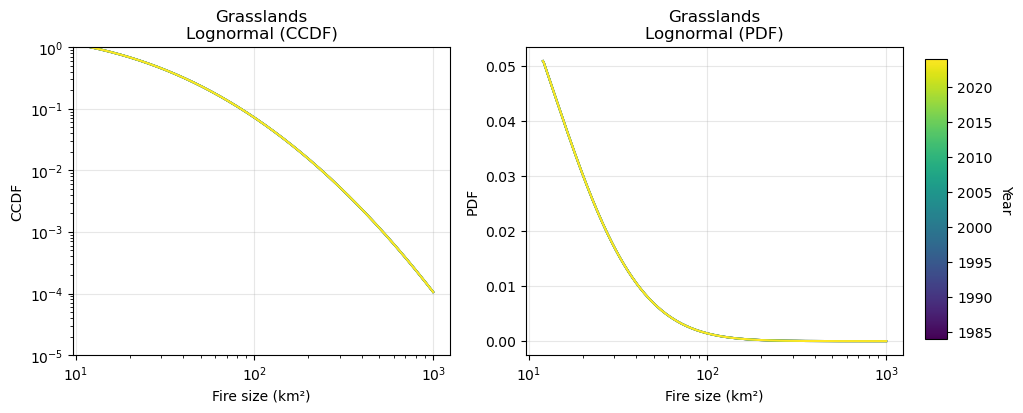

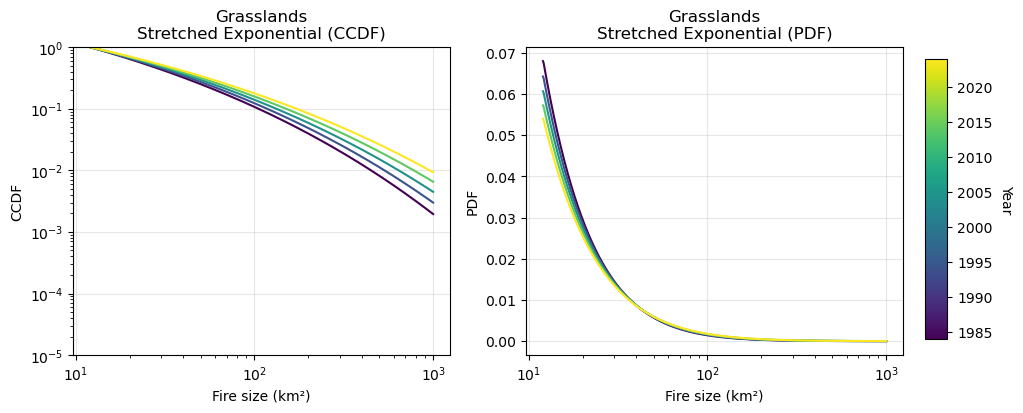

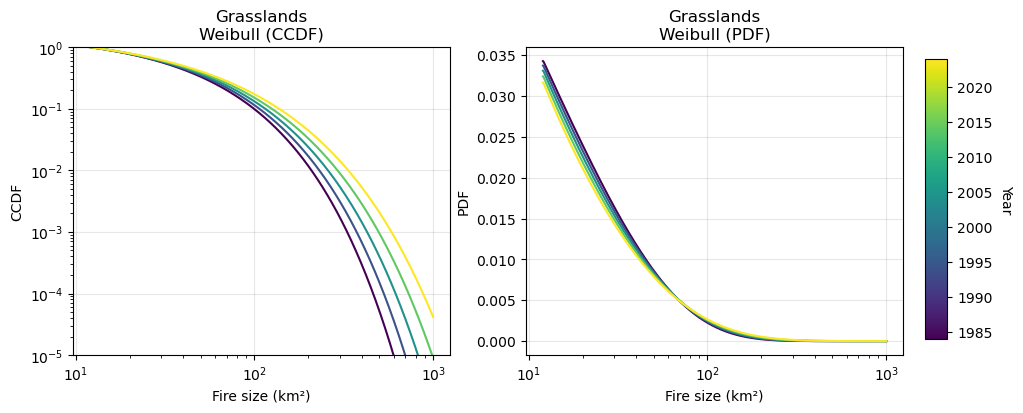

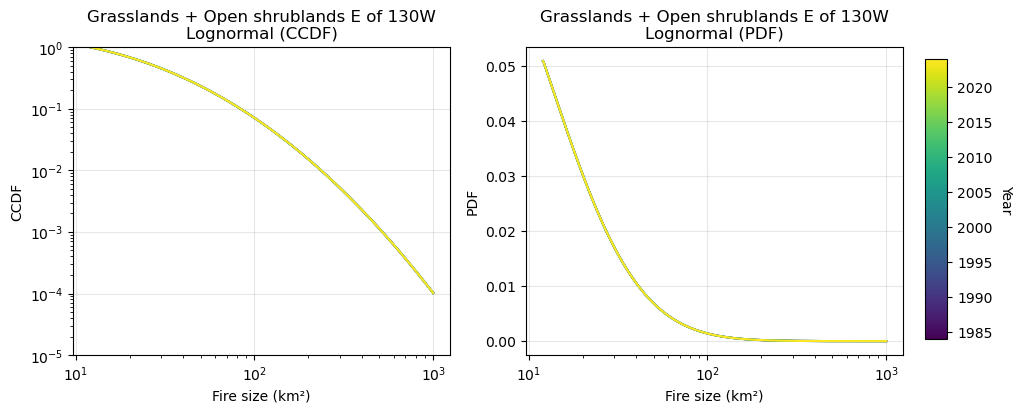

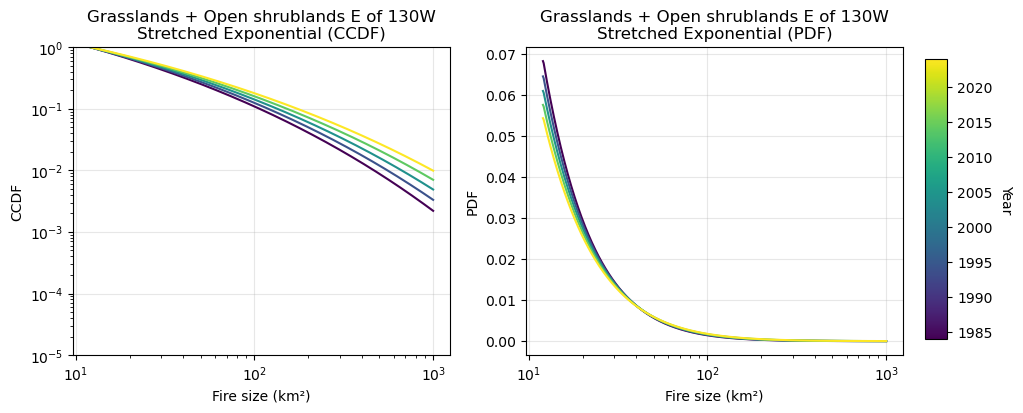

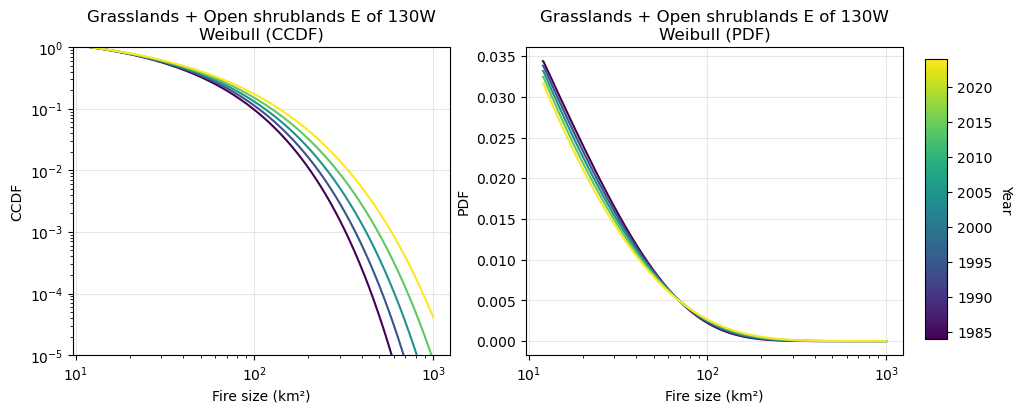

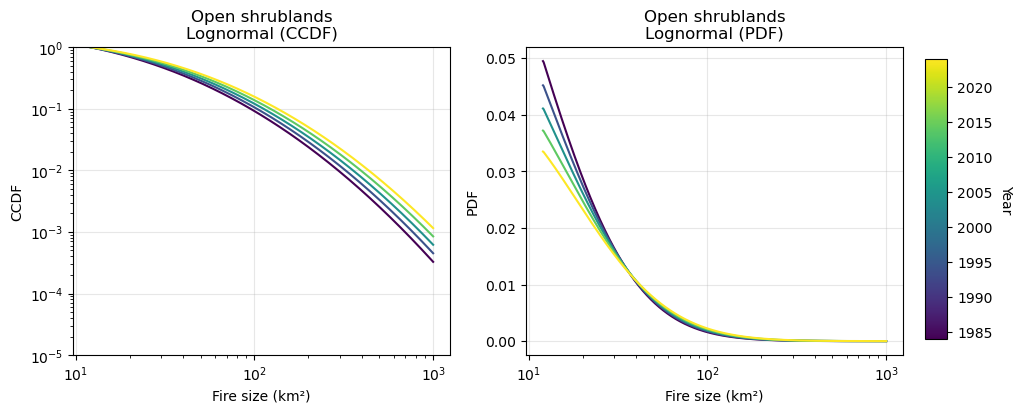

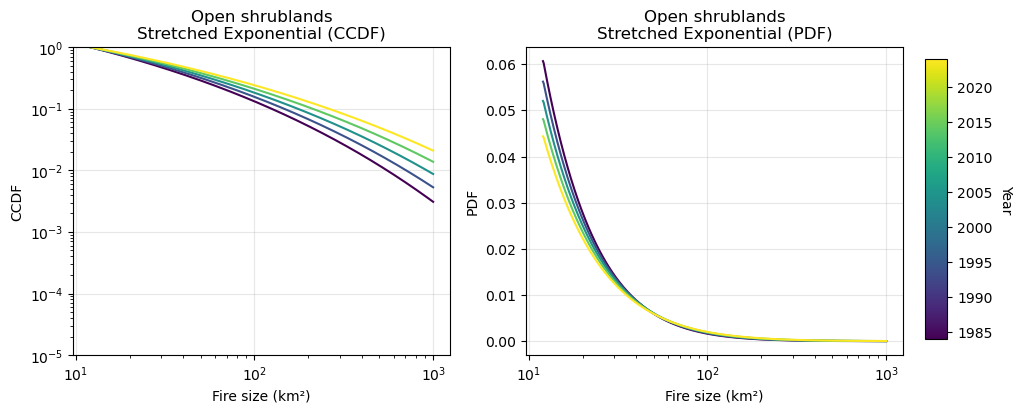

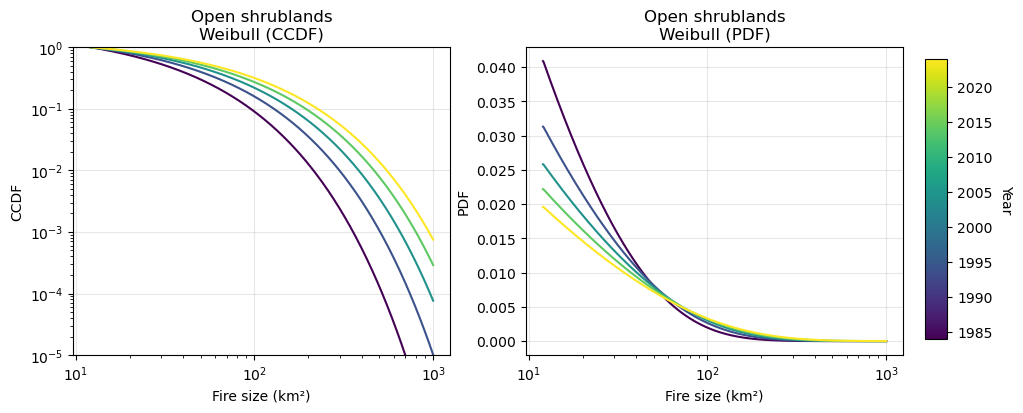

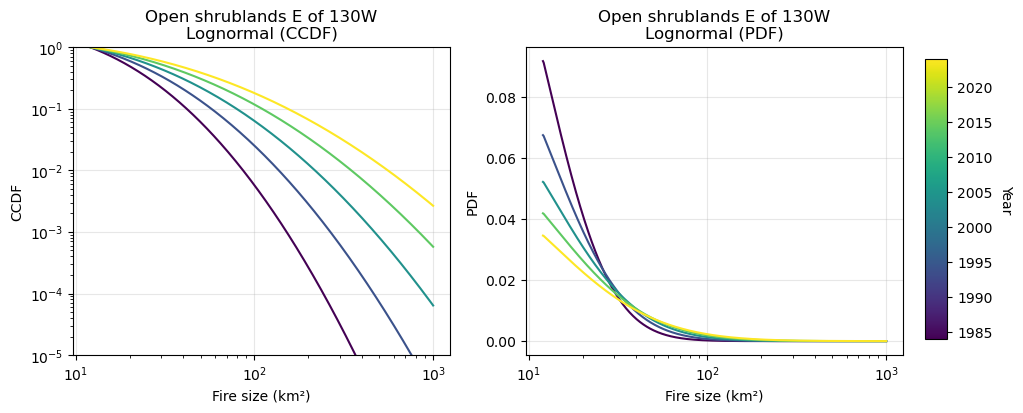

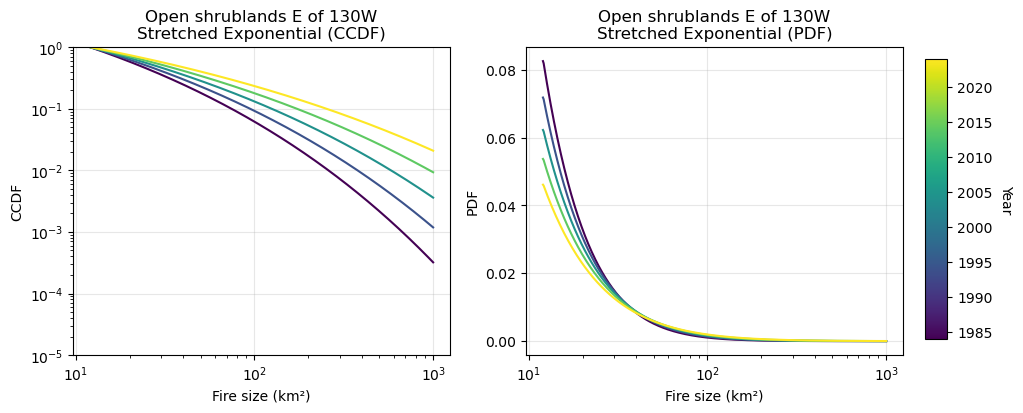

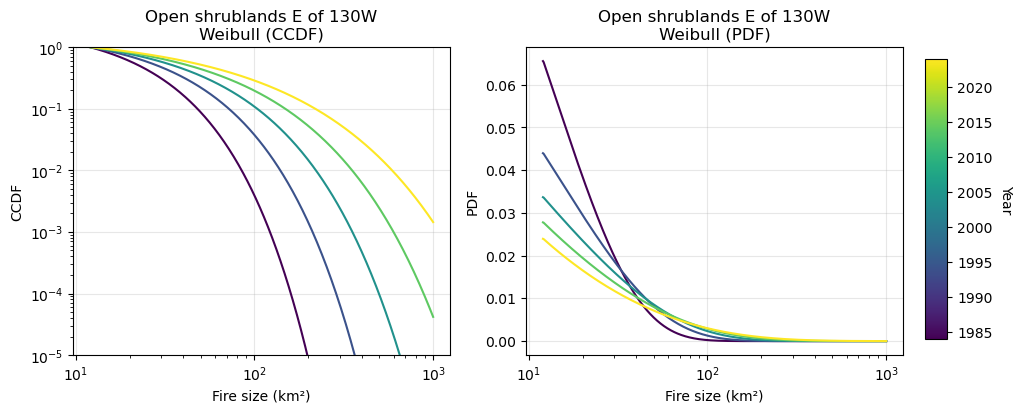

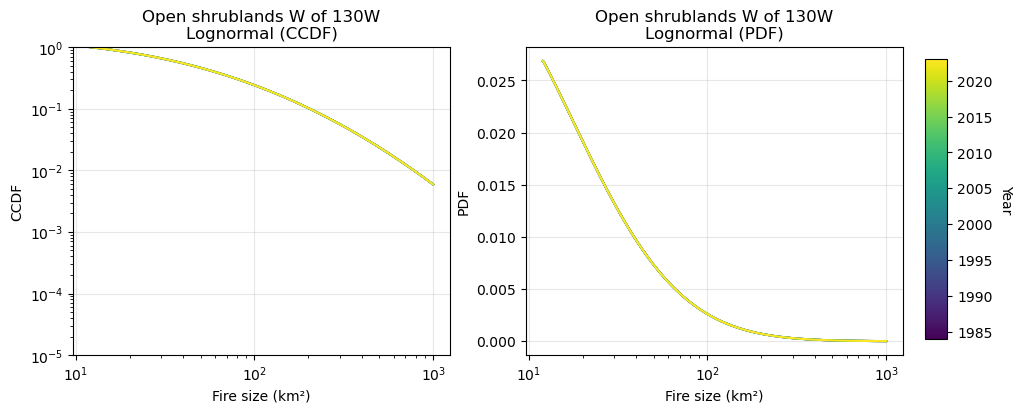

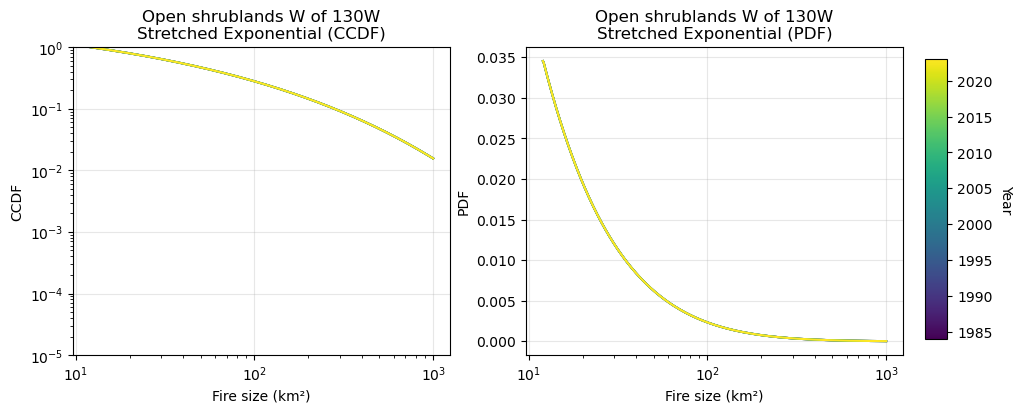

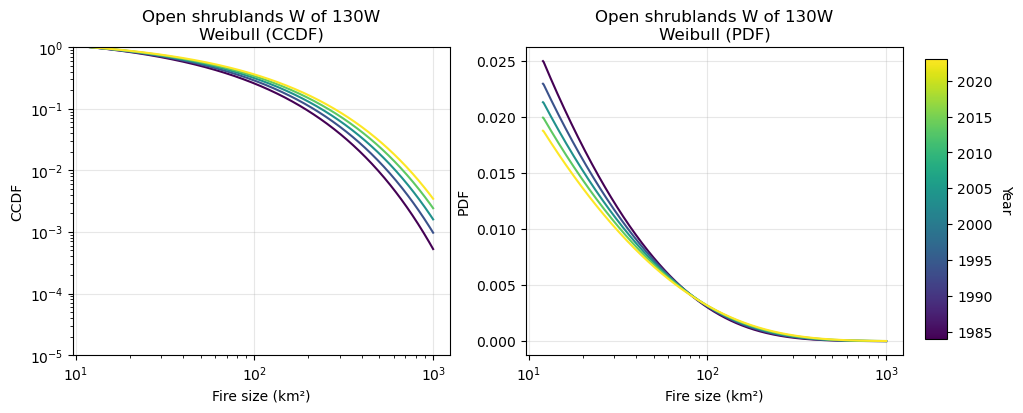

In [245]:
fit_poisson_tail_trend_by_biome_refined(mtbs_classified)
plot_refined_distribution_evolution_ccdf_pdf(
    df_both_refined, df_refined, df_p1_refined, df_p2_refined
)

Now, the same plotting visualizations on these refined groupings. This one now includes a 4th panel where the theoretical quantiles take into account the year of the fire and the (interpolated) distribution parameters in that year (from timevary_summary).

✅ Figure saved to ../data/open_shrublands_w_of_130w_cdf_ccdf_qq.png


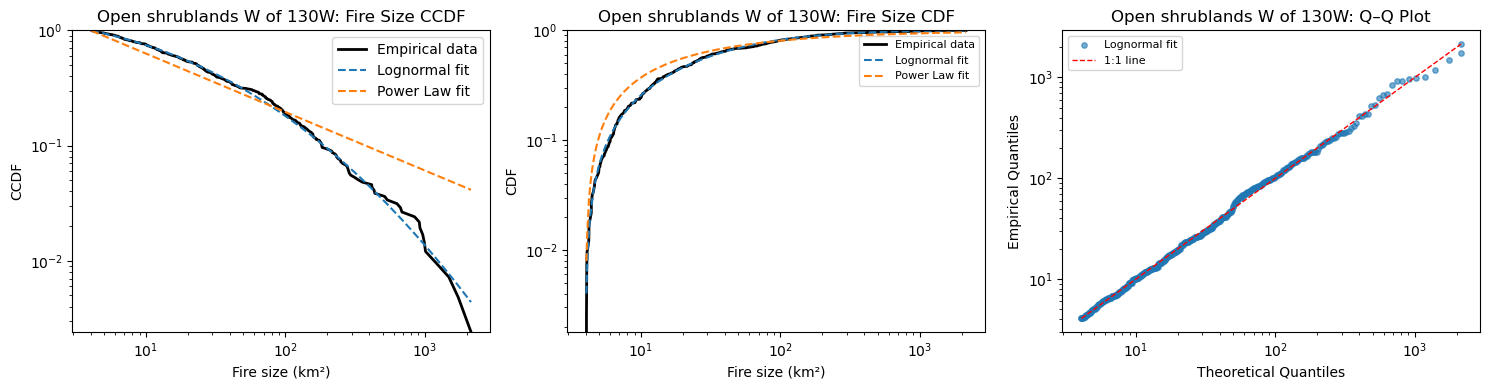

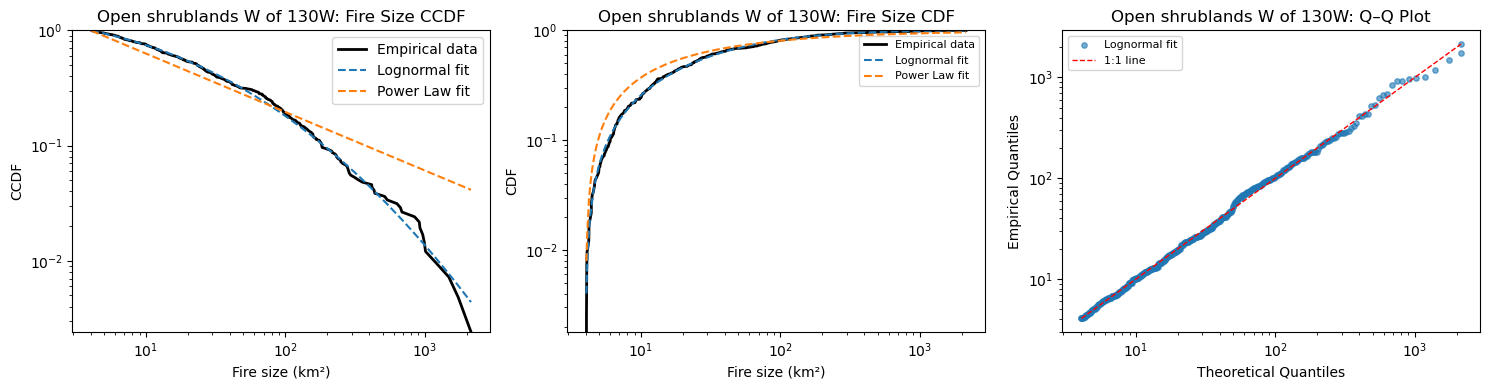

In [17]:
fig = plot_refined_biome_ccdf_cdf_qq(
    df_refined=df_refined,
    biome_refined="Open shrublands W of 130W",
    xmin=4,
    which=("lognormal",),
    save_dir="../data",
    year_col="year",
    timevary_summary=timevary_summary,
    timevary_dist="lognormal",
    trend_unit_years=10.0,
)

Next, we want to check: are we not seeing power law behavior because we are looking at too small of fires (as opposed to just the tail)? So, the following function incrementally increases the minimum fire size and refits the data for a given grouping. It returns the minimum fire size where a power law is a "good" fit for fires above that size (if one exists). It then returns visualizations showing how that power law fit looks on the entire dataset (left panel) and just the tail (right panel).


=== Open shrublands E of 130W — total fires ≥ 4 km²: n=1018 ===
  Trying tail threshold ≈ 11.20 km² (50.0th pct, n_tail=509)
there are 509 points above xmin 11.197918819707247 km^2
    power_law: alpha_hat=1.908, row_min_llhr=10.287, passes=False
  Trying tail threshold ≈ 15.32 km² (60.0th pct, n_tail=407)
there are 407 points above xmin 15.32362858019218 km^2
    power_law: alpha_hat=1.971, row_min_llhr=7.056, passes=False
  Trying tail threshold ≈ 21.97 km² (70.0th pct, n_tail=306)
there are 306 points above xmin 21.97208073044233 km^2
    power_law: alpha_hat=2.053, row_min_llhr=3.832, passes=False
  Trying tail threshold ≈ 32.83 km² (80.0th pct, n_tail=204)
there are 204 points above xmin 32.8283759019785 km^2
    power_law: alpha_hat=2.079, row_min_llhr=4.408, passes=False
  Trying tail threshold ≈ 44.82 km² (85.0th pct, n_tail=153)
there are 153 points above xmin 44.82494477897806 km^2
    power_law: alpha_hat=2.145, row_min_llhr=3.800, passes=False
  Trying tail threshold ≈ 69.

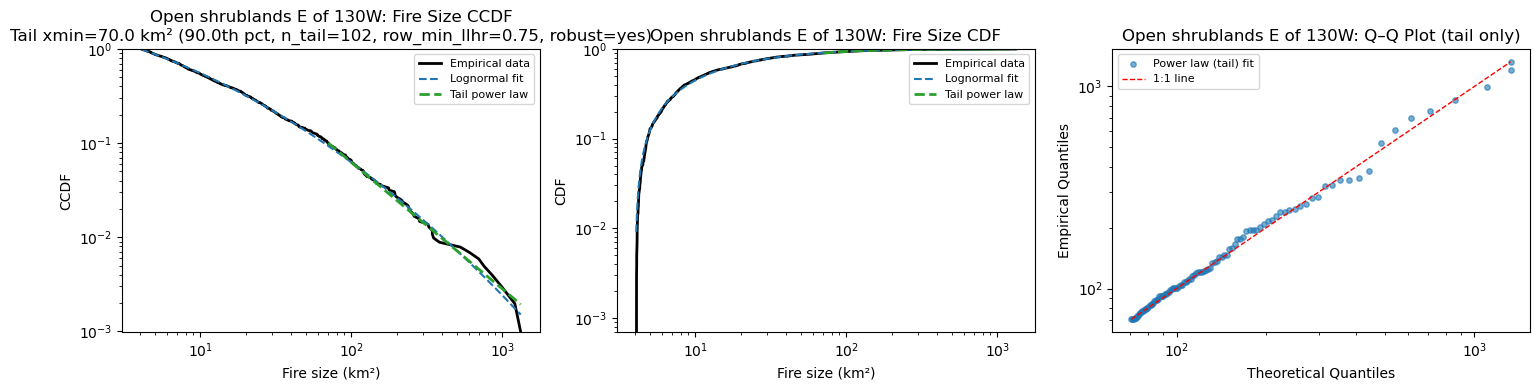

In [24]:
fig, tail_info = plot_refined_biome_tail_scan_ccdf_cdf_qq(
    df_refined=df_refined,
    biome_refined="Open shrublands E of 130W",
    xmin0=4,
    which=("lognormal",),  # or whatever you’ve been using
    candidate_percentiles=[50, 60, 70, 80, 85, 90, 92, 94, 96, 97, 98],
    min_tail_n=100,
    llhr_cutoff=2.0,
    R_boot_tail=20,
    save_dir="../data",
)